In [2]:
import pypsa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import numpy_financial as npf
import networkx as nx
from openpyxl import Workbook

In [3]:
# Load the input data
wind_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Data_Input_2022.xlsx', parse_dates=['Timestamp'])
market_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_high_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_Prices.xlsx', parse_dates=['Timestamp'])
Dynamic_containment_low_prices_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_Prices.xlsx', parse_dates=['Timestamp'])
dch_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCH_volume_mw.xlsx', parse_dates=['Timestamp'])
dcl_volume_data = pd.read_excel('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/DCL_volume_mw.xlsx', parse_dates=['Timestamp'])

# Set the 'Timestamp' column as the index
wind_data.set_index('Timestamp', inplace=True)
market_prices = market_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_prices = Dynamic_containment_high_prices_data.set_index('Timestamp')['Price (£/MWh)']
dcl_prices = Dynamic_containment_low_prices_data.set_index('Timestamp')['Price (£/MWh)']
dch_volume = dch_volume_data.set_index('Timestamp')['Volume (MW)']
dcl_volume = dcl_volume_data.set_index('Timestamp')['Volume (MW)']

# Ensure all data is aligned to the same index
market_prices = market_prices.reindex(wind_data.index, method='nearest')
dch_prices = dch_prices.reindex(wind_data.index, method='nearest')
dcl_prices = dcl_prices.reindex(wind_data.index, method='nearest')
dch_volume = dch_volume.reindex(wind_data.index, method='nearest')
dcl_volume = dcl_volume.reindex(wind_data.index, method='nearest')

# Add a generator for the wind farm
wind_generation_profile = wind_data['Wind Power Output (MW)']

# Add a load for the grid demand
demand_profile = wind_data['Load Demand (MW)']

# Initialize the network
network = pypsa.Network()

# Add time steps to the network
network.set_snapshots(wind_data.index)

# Add carriers
network.add("Carrier", "electricity")

# Add buses
network.add("Bus", "wind_bus", carrier="electricity")
network.add("Bus", "grid_bus", carrier="electricity")

# Add components to the network
network.add("Generator",
            "wind_turbine",
            bus="wind_bus",
            p_nom=84,  # Generator nominal power (MW)
            p_set=wind_generation_profile.values,  # Set power output directly
            marginal_cost=0,
            capital_cost=0)

network.add("StorageUnit",
            "battery",
            bus="wind_bus",
            p_nom_extendable=True,  # Make p_nom extendable
            max_hours=2,  # Maximum storage time in hours
            marginal_cost=0.01,  # Storage marginal cost
            capital_cost=626310, # GBP # To include the full SoC limits 20% - 80%
            cyclic_state_of_charge=True,
            state_of_charge_initial=0,
            efficiency_store=0.92,
            efficiency_dispatch=0.92)

network.add("Load",
            "grid_demand",
            bus="grid_bus",
            sign=-1,
            p_set=demand_profile.values)

network.add("Generator",
            "Backup Generator",
            bus="grid_bus",
            p_nom_extendable=True,
            marginal_cost=market_prices.values,
            capital_cost=1500000)


network.add("Generator",
            "DCH Service",
            bus="grid_bus",
            p_nom_extendable=True,  # Make p_nom extendable
            marginal_cost=dch_prices.values,
            capital_cost=1700000)


network.add("Generator",
            "DCL Service",
            bus="grid_bus",
            p_nom_extendable=True,  # Make p_nom extendable
            marginal_cost=dcl_prices.values,
            capital_cost=1600000)

network.add("Link",
            "wind_to_grid",
            bus0="wind_bus",
            bus1="grid_bus",
            efficiency=0.95,
            p_nom=82)

network.add("Link",
            "grid_to_wind",
            bus0="grid_bus",
            bus1="wind_bus",
            efficiency=0.95,
            p_nom=82)

# Optimize the network
network.optimize(network.snapshots, solver_name='gurobi', keep_files=True)

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 100.80it/s]
INFO:linopy.io: Writing time: 0.68s


Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-3rfgmi86.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/linopy-problem-3rfgmi86.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 192196 rows, 78628 columns, 340708 nonzeros


INFO:gurobipy:obj: 192196 rows, 78628 columns, 340708 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


INFO:gurobipy:Optimize a model with 192196 rows, 78628 columns and 340708 nonzeros


Model fingerprint: 0x6d21dd03


INFO:gurobipy:Model fingerprint: 0x6d21dd03


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-01, 2e+00]


INFO:gurobipy:  Matrix range     [9e-01, 2e+00]


  Objective range  [1e-02, 2e+06]


INFO:gurobipy:  Objective range  [1e-02, 2e+06]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+04]


INFO:gurobipy:  RHS range        [1e-03, 9e+04]


Presolve removed 113578 rows and 8742 columns


INFO:gurobipy:Presolve removed 113578 rows and 8742 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:Presolved: 78618 rows, 69886 columns, 218394 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 4


INFO:gurobipy: Dense cols : 4


 AA' NZ     : 1.572e+05


INFO:gurobipy: AA' NZ     : 1.572e+05


 Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 8.648e+05 (roughly 70 MB of memory)


 Factor Ops : 1.004e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.004e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


INFO:gurobipy:   0   3.29359736e+11 -2.63444128e+10  8.47e+04 3.22e+01  4.24e+08     0s


   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


INFO:gurobipy:   1   4.31326817e+11 -1.37465569e+12  1.94e+04 1.79e+03  8.90e+07     0s


   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


INFO:gurobipy:   2   3.99280210e+11 -3.76101210e+11  3.90e+03 1.32e+02  1.39e+07     0s


   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


INFO:gurobipy:   3   2.37451176e+11  5.17081436e+10  8.92e+02 2.43e+00  2.35e+06     0s


   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


INFO:gurobipy:   4   1.96860695e+11  8.32781577e+10  5.77e+02 5.82e-10  1.25e+06     0s


   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


INFO:gurobipy:   5   1.90579530e+11  9.52872582e+10  4.84e+02 3.73e-09  1.00e+06     0s


   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


INFO:gurobipy:   6   1.84833805e+11  1.11502153e+11  4.13e+02 6.40e-10  7.44e+05     0s


   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


INFO:gurobipy:   7   1.67759192e+11  1.34151158e+11  1.63e+02 1.16e-09  2.88e+05     0s


   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


INFO:gurobipy:   8   1.60202460e+11  1.44892517e+11  6.99e+01 1.79e-08  1.12e+05     0s


   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


INFO:gurobipy:   9   1.56465991e+11  1.50084378e+11  2.68e+01 2.91e-09  4.21e+04     0s


  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


INFO:gurobipy:  10   1.54940929e+11  1.51807467e+11  1.23e+01 1.54e-08  1.98e+04     0s


  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


INFO:gurobipy:  11   1.54077334e+11  1.52729684e+11  5.41e+00 3.59e-08  8.33e+03     0s


  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


INFO:gurobipy:  12   1.53525506e+11  1.53046211e+11  1.60e+00 3.26e-08  2.93e+03     0s


  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


INFO:gurobipy:  13   1.53436912e+11  1.53144488e+11  1.17e+00 2.19e-07  1.79e+03     0s


  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


INFO:gurobipy:  14   1.53370909e+11  1.53159244e+11  8.42e-01 1.97e-07  1.29e+03     1s


  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


INFO:gurobipy:  15   1.53308866e+11  1.53177121e+11  5.33e-01 1.56e-07  8.04e+02     1s


  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


INFO:gurobipy:  16   1.53290011e+11  1.53180211e+11  4.34e-01 1.39e-07  6.70e+02     1s


  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


INFO:gurobipy:  17   1.53274843e+11  1.53190498e+11  3.60e-01 8.68e-08  5.15e+02     1s


  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


INFO:gurobipy:  18   1.53268441e+11  1.53219520e+11  2.54e-01 3.67e-08  2.99e+02     1s


  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


INFO:gurobipy:  19   1.53255960e+11  1.53240578e+11  7.54e-02 4.10e-08  9.39e+01     1s


  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


INFO:gurobipy:  20   1.53251938e+11  1.53245550e+11  3.26e-02 2.07e-08  3.90e+01     1s


  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


INFO:gurobipy:  21   1.53249784e+11  1.53247631e+11  1.11e-02 1.13e-08  1.31e+01     1s


  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


INFO:gurobipy:  22   1.53249100e+11  1.53248107e+11  5.04e-03 2.50e-09  6.06e+00     1s


  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


INFO:gurobipy:  23   1.53248724e+11  1.53248275e+11  1.92e-03 5.47e-09  2.73e+00     1s


  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


INFO:gurobipy:  24   1.53248537e+11  1.53248402e+11  4.41e-04 1.12e-08  8.19e-01     1s


  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


INFO:gurobipy:  25   1.53248506e+11  1.53248448e+11  3.32e-04 1.37e-08  3.50e-01     1s


  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


INFO:gurobipy:  26   1.53248492e+11  1.53248461e+11  2.89e-04 1.98e-09  1.90e-01     1s


  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


INFO:gurobipy:  27   1.53248480e+11  1.53248467e+11  1.73e-04 3.38e-09  7.48e-02     1s


  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


INFO:gurobipy:  28   1.53248477e+11  1.53248472e+11  1.15e-04 3.49e-10  3.36e-02     1s


  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


INFO:gurobipy:  29   1.53248476e+11  1.53248474e+11  5.82e-05 6.87e-09  1.08e-02     1s


  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


INFO:gurobipy:  30   1.53248476e+11  1.53248475e+11  1.96e-05 5.70e-09  2.69e-03     1s


  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


INFO:gurobipy:  31   1.53248476e+11  1.53248476e+11  6.52e-06 1.93e-09  7.31e-04     1s


  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


INFO:gurobipy:  32   1.53248476e+11  1.53248476e+11  1.46e-06 7.80e-09  2.80e-04     1s


  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


INFO:gurobipy:  33   1.53248476e+11  1.53248476e+11  1.53e-07 8.87e-08  1.99e-05     1s


  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


INFO:gurobipy:  34   1.53248476e+11  1.53248476e+11  2.12e-08 2.13e-07  6.89e-07     1s


  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:  35   1.53248476e+11  1.53248476e+11  4.25e-09 1.48e-07  1.81e-09     1s


INFO:gurobipy:


Barrier solved model in 35 iterations and 0.97 seconds (1.44 work units)


INFO:gurobipy:Barrier solved model in 35 iterations and 0.97 seconds (1.44 work units)


Optimal objective 1.53248476e+11


INFO:gurobipy:Optimal objective 1.53248476e+11


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    2803 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:    2803 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    4320 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    4320 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   48692    1.5324848e+11   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 48692 iterations and 1.07 seconds (1.82 work units)


INFO:gurobipy:Solved in 48692 iterations and 1.07 seconds (1.82 work units)


Optimal objective  1.532484756e+11


INFO:gurobipy:Optimal objective  1.532484756e+11
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78628 primals, 192196 duals
Objective: 1.53e+11
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-p_set, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [4]:
# Extract optimization results
battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]
battery_capacity_mwh = battery_size_mw * network.storage_units.loc["battery", "max_hours"]

# Extract flows using p_dispatch and p_store
battery_dispatch = network.storage_units_t.p_dispatch["battery"]
battery_store = network.storage_units_t.p_store["battery"]
wind_generation = network.generators_t.p["wind_turbine"]
backup_generation = network.generators_t.p["Backup Generator"]
DCH_generation = network.generators_t.p["DCH Service"]
DCL_generation = network.generators_t.p["DCL Service"]
load_demand = network.loads_t.p["grid_demand"]
soc = network.storage_units_t["state_of_charge"]["battery"]
soc_percentage = soc / battery_capacity_mwh * 100

# Calculate total energy
total_battery_dispatch = battery_dispatch.sum()
total_battery_store = battery_store.sum()
total_wind_generation = wind_generation.sum()
total_dch_generation = DCH_generation.sum()
total_dcl_generation = DCL_generation.sum()
total_backup_generation = backup_generation.sum()
total_load_demand = load_demand.sum()

# Print results

print("")
print("Optimal Battery Size:")
print("Optimized Battery Size (MW):", battery_size_mw)
print("Optimized Battery Capacity (MWh):", battery_capacity_mwh)

print("_________________________________________________")
print("")
print("Co-located Bus:")
print(f"Total Battery Dispatch (MWh): {total_battery_dispatch:.2f}")
print(f"Total Battery Store (MWh): {total_battery_store:.2f}")
print(f"Total Wind Generation (MWh): {total_wind_generation:.2f}")

print("_________________________________________________")
print("")
print("Grid Bus:")
print(f"Total DCH to Grid (MWh): {total_dch_generation:.2f}")
print(f"Total DCL to Grid (MWh): {total_dcl_generation:.2f}")
print(f"Total Backup Generation (MWh): {total_backup_generation:.2f}")
print(f"Total Load Demand (MWh): {total_load_demand:.2f}")

# Combine data into a DataFrame
results_df = pd.DataFrame({
    'Timestamp': wind_data.index,
    'Market Price (£/MWh)': market_prices,
    'DCH Price (£/MWh)': dch_prices,
    'DCL Price (£/MWh)': dcl_prices,
    'Battery Dispatch (MW)': battery_dispatch,
    'Battery Store (MW)': battery_store,
    'Wind Generation (MW)': wind_generation,
    'Backup Generation (MW)': backup_generation,
    'DCH Generation (MW)': DCH_generation,
    'DCL Generation (MW)': DCL_generation,
    'Load Demand (MW)': load_demand,
    'State of Charge (MWh)': soc,
    'State of Charge (%)': soc_percentage
})

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_2022_Two_Buses.xlsx'
results_df.to_excel(output_path, index=False)
print("_________________________________________________")
print("")
print(f"Results saved to {output_path}")


Optimal Battery Size:
Optimized Battery Size (MW): 79.998
Optimized Battery Capacity (MWh): 159.996
_________________________________________________

Co-located Bus:
Total Battery Dispatch (MWh): 81880.02
Total Battery Store (MWh): 96739.16
Total Wind Generation (MWh): 197624.15
_________________________________________________

Grid Bus:
Total DCH to Grid (MWh): 269588323.76
Total DCL to Grid (MWh): 192795461.70
Total Backup Generation (MWh): 2585613.10
Total Load Demand (MWh): 465137704.00
_________________________________________________

Results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_2022_Two_Buses.xlsx


In [5]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Calculate revenues
cfd_strike_price = 245.29  # GBP/MWh for wind energy

# Calculate CFD Revenue (No Arbitrage Cost, as the wind and battery are on same bus)
data['Arbitrage Cost (£)'] = data['Battery Store (MW)'] * data['Market Price (£/MWh)']

data['CFD Revenue (£)'] = data['Wind Generation (MW)'] * cfd_strike_price
data['Arbitrage Revenue (£)'] = data['Battery Dispatch (MW)'] * data['Market Price (£/MWh)'] 
data['DCL Revenue (£)'] = data['Battery Dispatch (MW)'] * data['DCL Price (£/MWh)']
data['DCH Revenue (£)'] = data['Battery Store (MW)'] * data['DCH Price (£/MWh)']
data['Battery Revenue (£)'] = data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)']

data['Total Project Revenue (£)'] = data['CFD Revenue (£)'] + data['DCL Revenue (£)'] + data['DCH Revenue (£)'] + data['Arbitrage Revenue (£)']


# Print revenue summaries
print("")
print(f"Wind Farm Revenue (With No Batteries) (£/year): {data['CFD Revenue (£)'].sum():.2f}")
print("_________________________________________________")

print("Co-located Project Revenue:")
print("")
print(f"Wind Farm Revenue (£/year): {data['CFD Revenue (£)'].sum():.2f}")
print(f"Battery Revenue (£/year): {data['Battery Revenue (£)'].sum():.2f}")
print(f"Total Co-located Project Revenue (£/year): {data['Total Project Revenue (£)'].sum():.2f}")
print("_________________________________________________")

print("Battery Revenue Breakdown:")
print("")
print(f"Arbitrage Revenue (£/year): {data['Arbitrage Revenue (£)'].sum():.2f}")
print(f"DCL Revenue (£/year): {data['DCL Revenue (£)'].sum():.2f}")
print(f"DCH Revenue (£/year): {data['DCH Revenue (£)'].sum():.2f}")
print(f"Battery Revenue (£/year): {(data['Battery Revenue (£)'].sum()):.2f}")
print(f"Battery Revenue (£/MW/year): {(data['Battery Revenue (£)'].sum()/battery_size_mw):.2f}")

# Save the results to an Excel sheet
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data.to_excel(output_path, index=False)
print("_________________________________________________")
print("")
print(f"Results saved to {output_path}")



Wind Farm Revenue (With No Batteries) (£/year): 48475228.73
_________________________________________________
Co-located Project Revenue:

Wind Farm Revenue (£/year): 48475228.73
Battery Revenue (£/year): 19875158.22
Total Co-located Project Revenue (£/year): 68350386.95
_________________________________________________
Battery Revenue Breakdown:

Arbitrage Revenue (£/year): 17455791.50
DCL Revenue (£/year): 2140186.66
DCH Revenue (£/year): 279180.06
Battery Revenue (£/year): 19875158.22
Battery Revenue (£/MW/year): 248445.69
_________________________________________________

Results saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx


In [6]:
# Load the previously saved optimization results
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Extract annual battery revenue
annual_battery_revenue = data['Battery Revenue (£)'].sum()
battery_size_mw = network.storage_units.loc["battery", "p_nom_opt"]

# Project parameters
discount_rate = 0.07
battery_lifetime = 15
capex_per_mw = 626310
opex_per_mw_per_year = 28728
price_escalation_rate = 0.10

# Total CAPEX
total_capex = battery_size_mw * capex_per_mw

# Calculate annual battery revenues with escalation
annual_battery_revenues = [(annual_battery_revenue * (1 + price_escalation_rate) ** year) for year in range(battery_lifetime)]
annual_opex = [(opex_per_mw_per_year * battery_size_mw * (1 + price_escalation_rate) ** year) for year in range(battery_lifetime)]
annual_cash_flows = [revenue - opex for revenue, opex in zip(annual_battery_revenues, annual_opex)]
annual_cash_flows.insert(0, -total_capex)  # Initial investment in year 0

# NPV Calculation
npv = npf.npv(discount_rate, annual_cash_flows)

# IRR Calculation
irr = npf.irr(annual_cash_flows) * 100  # Convert to percentage

# Total discounted OPEX
total_opex = sum([opex / ((1 + discount_rate) ** year) for year, opex in enumerate(annual_opex, start=1)])

# Total discounted costs
total_discounted_costs = total_capex + total_opex

# Total energy dispatched over the lifetime (MWh)
total_energy_dispatched = total_battery_dispatch * battery_lifetime

# LCOS Calculation
lcos = total_discounted_costs / total_energy_dispatched

# Payback Period Calculation
cumulative_cash_flow = 0
payback_period = None
for year, cash_flow in enumerate(annual_cash_flows):
    cumulative_cash_flow += cash_flow
    if cumulative_cash_flow >= 0 and payback_period is None:
        payback_period = year

# Print results
print(f"Battery Net Present Value (NPV): £{npv:.2f}")
print(f"Battery Internal Rate of Return (IRR): {irr:.2f}%")
print(f"Battery Levelized Cost of Storage (LCOS): £{lcos:.2f}/MWh")
print(f"Payback Period: {payback_period} years")
print(f"Total Discounted OPEX: £{total_opex:.2f}")
print(f"Total CAPEX: £{total_capex:.2f}")
print(f"Total Costs: £{total_discounted_costs:.2f}")

# Export annual cash flows to Excel
wb = Workbook()
ws = wb.active
ws.title = "Annual Cash Flows"

# Add headers
ws.append(["Year", "Cash Flow"])

# Add data
for year, cash_flow in enumerate(annual_cash_flows):
    ws.append([year, cash_flow])

# Save the workbook
export_file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Annual_Cash_Flows.xlsx'
wb.save(export_file_path)

print(f"Annual cash flows have been exported to {export_file_path}")


Battery Net Present Value (NPV): £251064438.75
Battery Internal Rate of Return (IRR): 44.49%
Battery Levelized Cost of Storage (LCOS): £72.86/MWh
Payback Period: 3 years
Total Discounted OPEX: £39377593.81
Total CAPEX: £50103547.38
Total Costs: £89481141.19
Annual cash flows have been exported to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Annual_Cash_Flows.xlsx


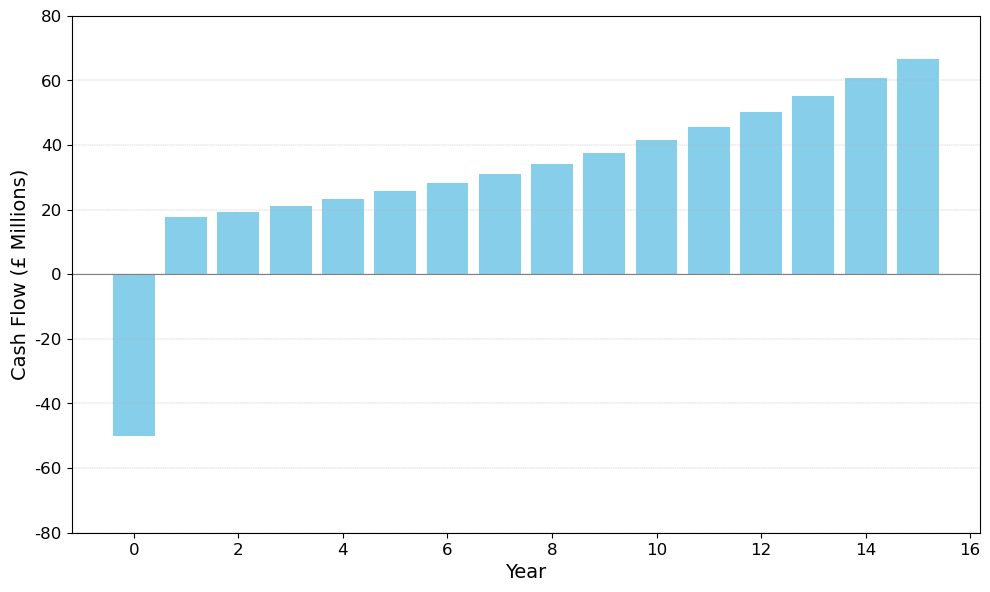

Annual cash flows plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Annual_Cash_Flows_Plot.png


In [7]:
# Load the previously saved annual cash flows
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Annual_Cash_Flows.xlsx'
cash_flows_df = pd.read_excel(file_path)

# Convert cash flows to millions
cash_flows_df['Cash Flow'] = cash_flows_df['Cash Flow'] / 1e6

# Plot the annual cash flows
plt.figure(figsize=(10, 6))
plt.bar(cash_flows_df['Year'], cash_flows_df['Cash Flow'], color='skyblue')
plt.axhline(0, color='gray', linewidth=0.8)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cash Flow (£ Millions)', fontsize=14)
plt.ylim(-80, 80)
plt.yticks(range(-80, 81, 20), fontsize=12)  # Set ticks at intervals of 10
plt.grid(axis='y', linestyle='--', linewidth=0.3)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Annual_Cash_Flows_Plot.png'
plt.savefig(output_plot_path)
plt.show()

print(f"Annual cash flows plot saved to {output_plot_path}")


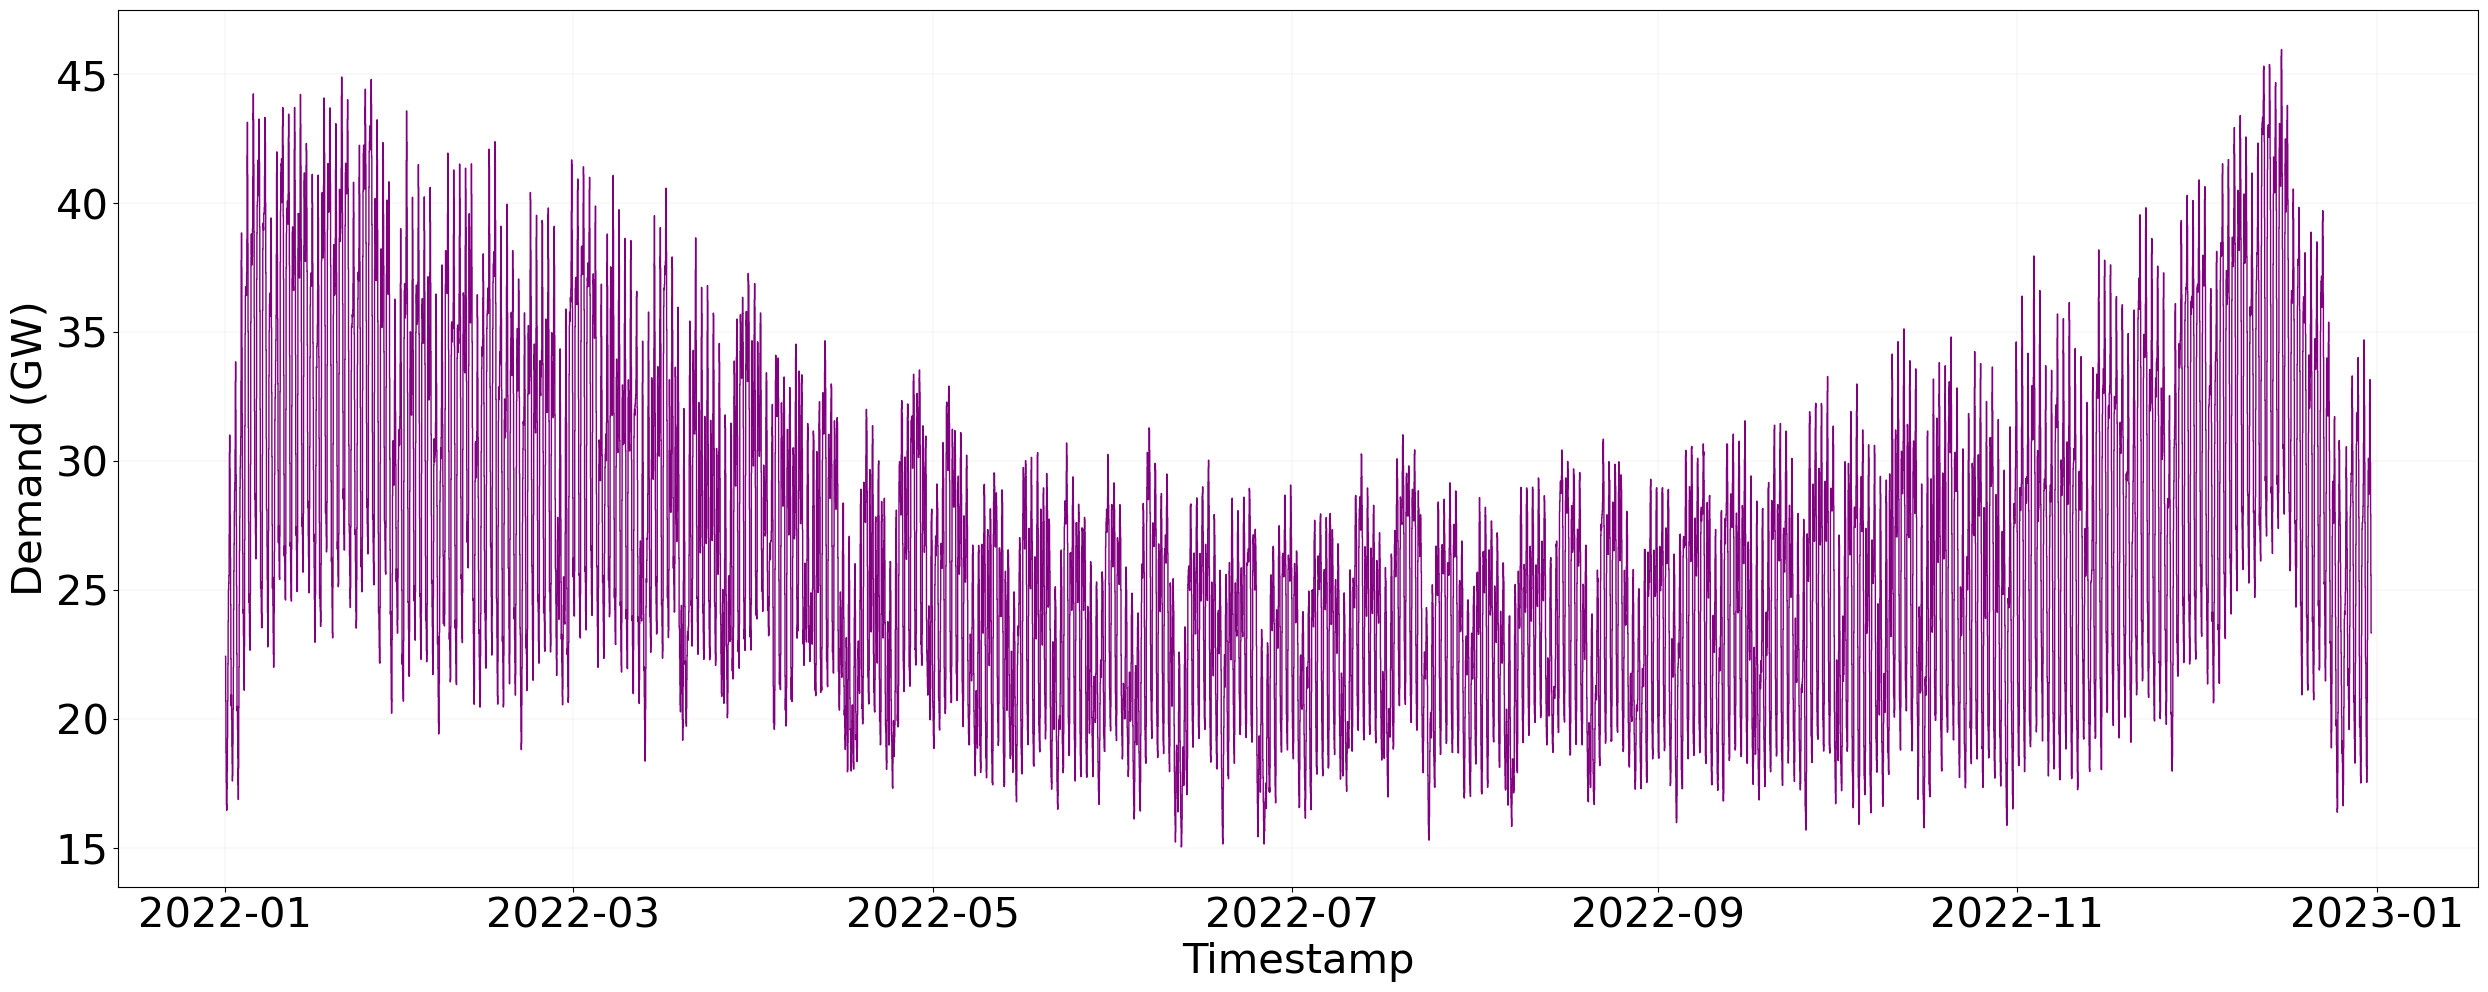

In [8]:
# Load the data from the specified Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/Demand_UK_2022_Final_for_plot_only.xlsx'
wind_data = pd.read_excel(file_path, index_col=0)

# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Convert index to datetime if not already
wind_data.index = pd.to_datetime(wind_data.index)

# Filter the data for the specified time range
filtered_data = wind_data.loc[start_date:end_date]

# Plot load demand over time
plt.figure(figsize=(25, 10))
plt.step(filtered_data.index, filtered_data['Load Demand (MW)']/1000, label='Load Demand', color='purple', where='mid', linewidth=1, linestyle='-')
plt.xlabel('Timestamp', fontsize=30)  # Adjusted font size
plt.ylabel('Demand (GW)', fontsize=30)  # Adjusted font size

# Increase the font size of the tick labels
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)

# Adjust layout to prevent cutting off y-axis labels
plt.tight_layout(pad=1.0)

# Save the plot
plt.savefig('/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/load_demand_plot.png', dpi=300)
plt.show()


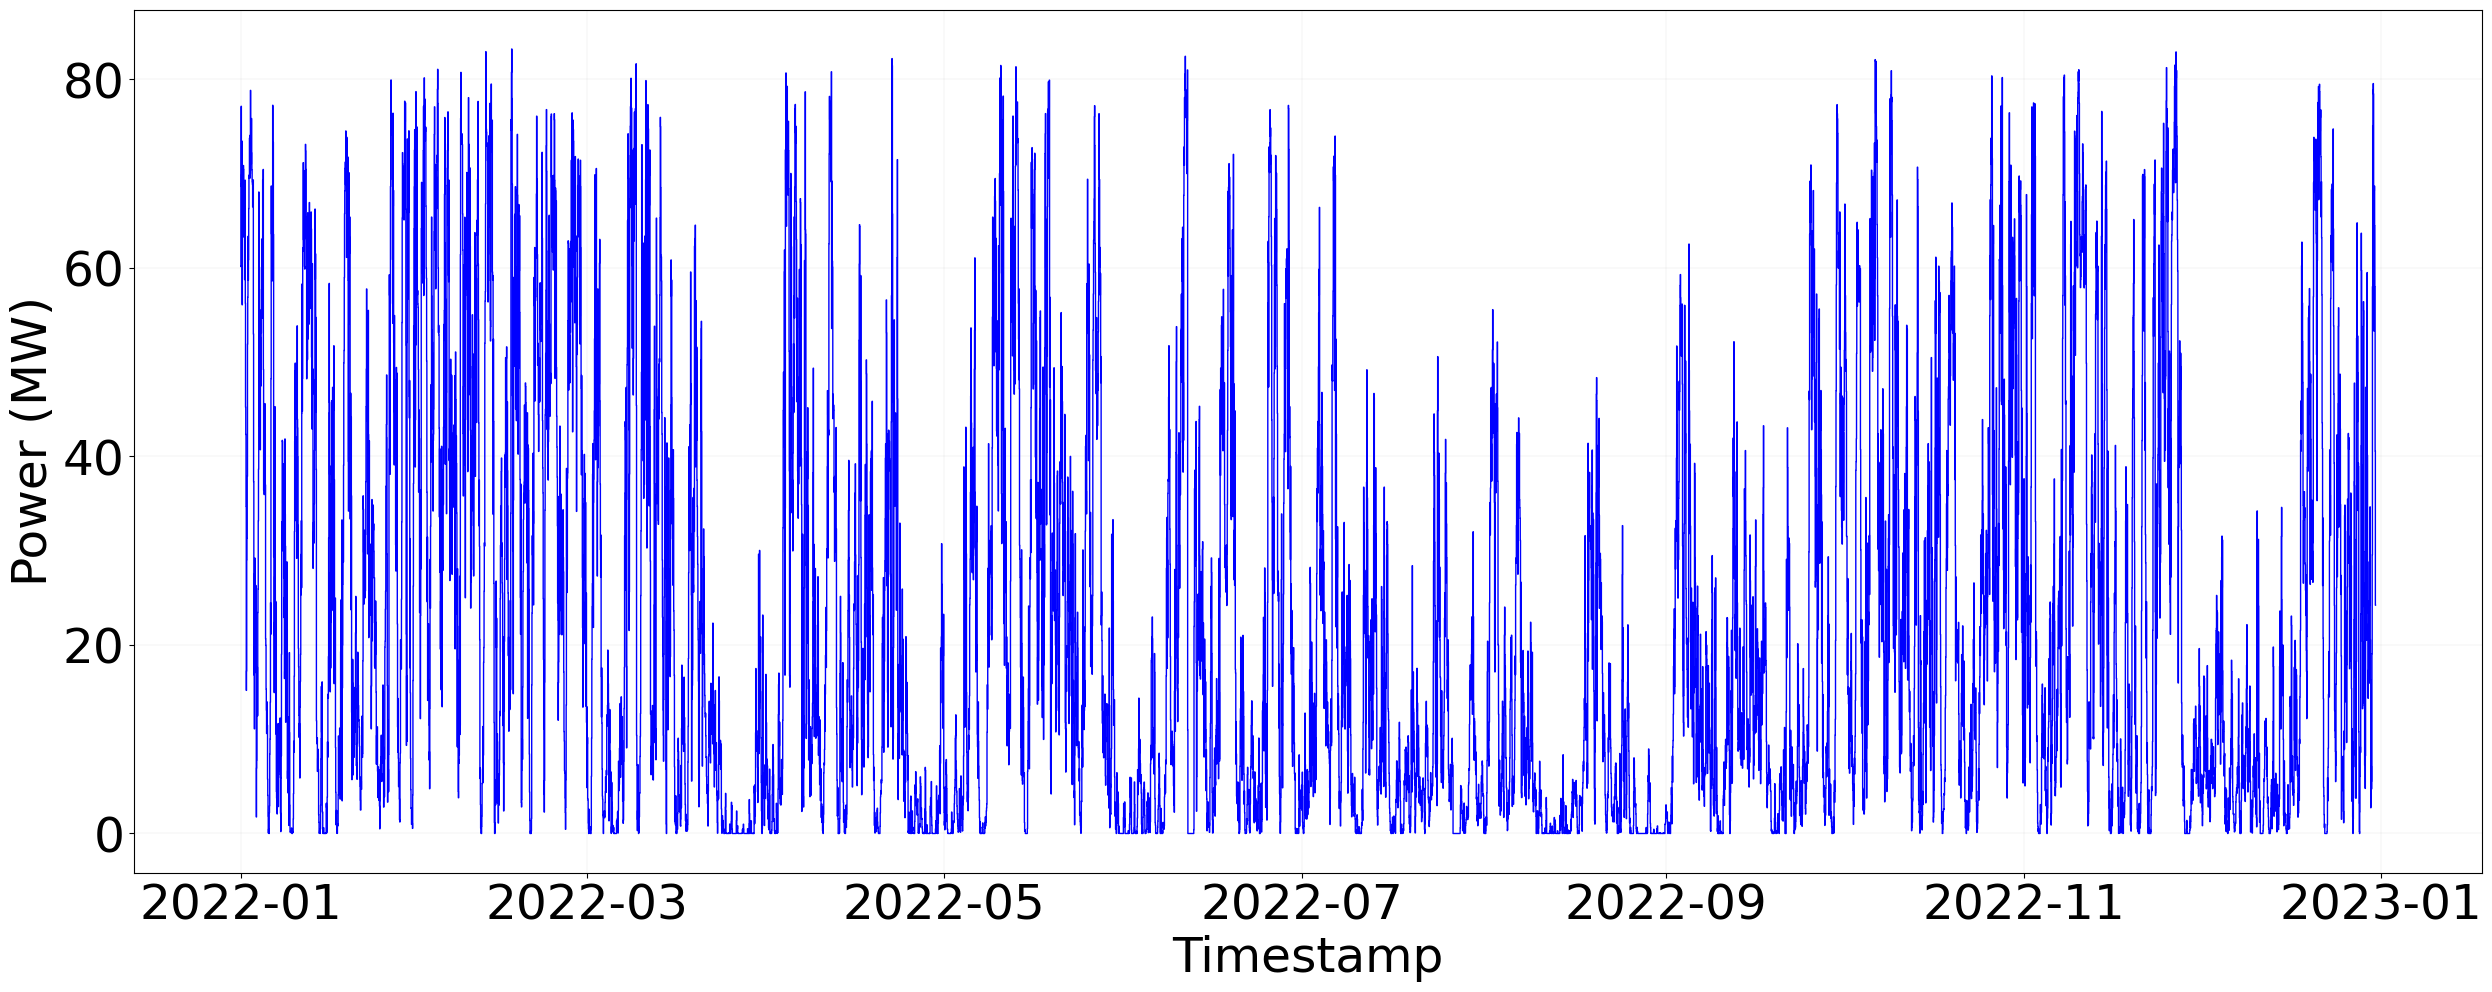

In [9]:
# Filter the data for the specified time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Ensure 'Timestamp' is in datetime format
wind_data.index = pd.to_datetime(wind_data.index)

filtered_wind_generation = wind_generation_profile.loc[start_date:end_date]

# Plot wind generation over time
plt.figure(figsize=(25, 10))
plt.step(filtered_wind_generation.index, filtered_wind_generation.values, label='Wind Generation', color='b', where='mid', linewidth=1, linestyle='-')
plt.xlabel('Timestamp', fontsize=35)
plt.ylabel('Power (MW)', fontsize=35)
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.tight_layout(pad=1.0)

# Save the plot
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/Wind_Generation_Plot.png'
plt.savefig(output_path, dpi=300)

# Show the plot
plt.show()


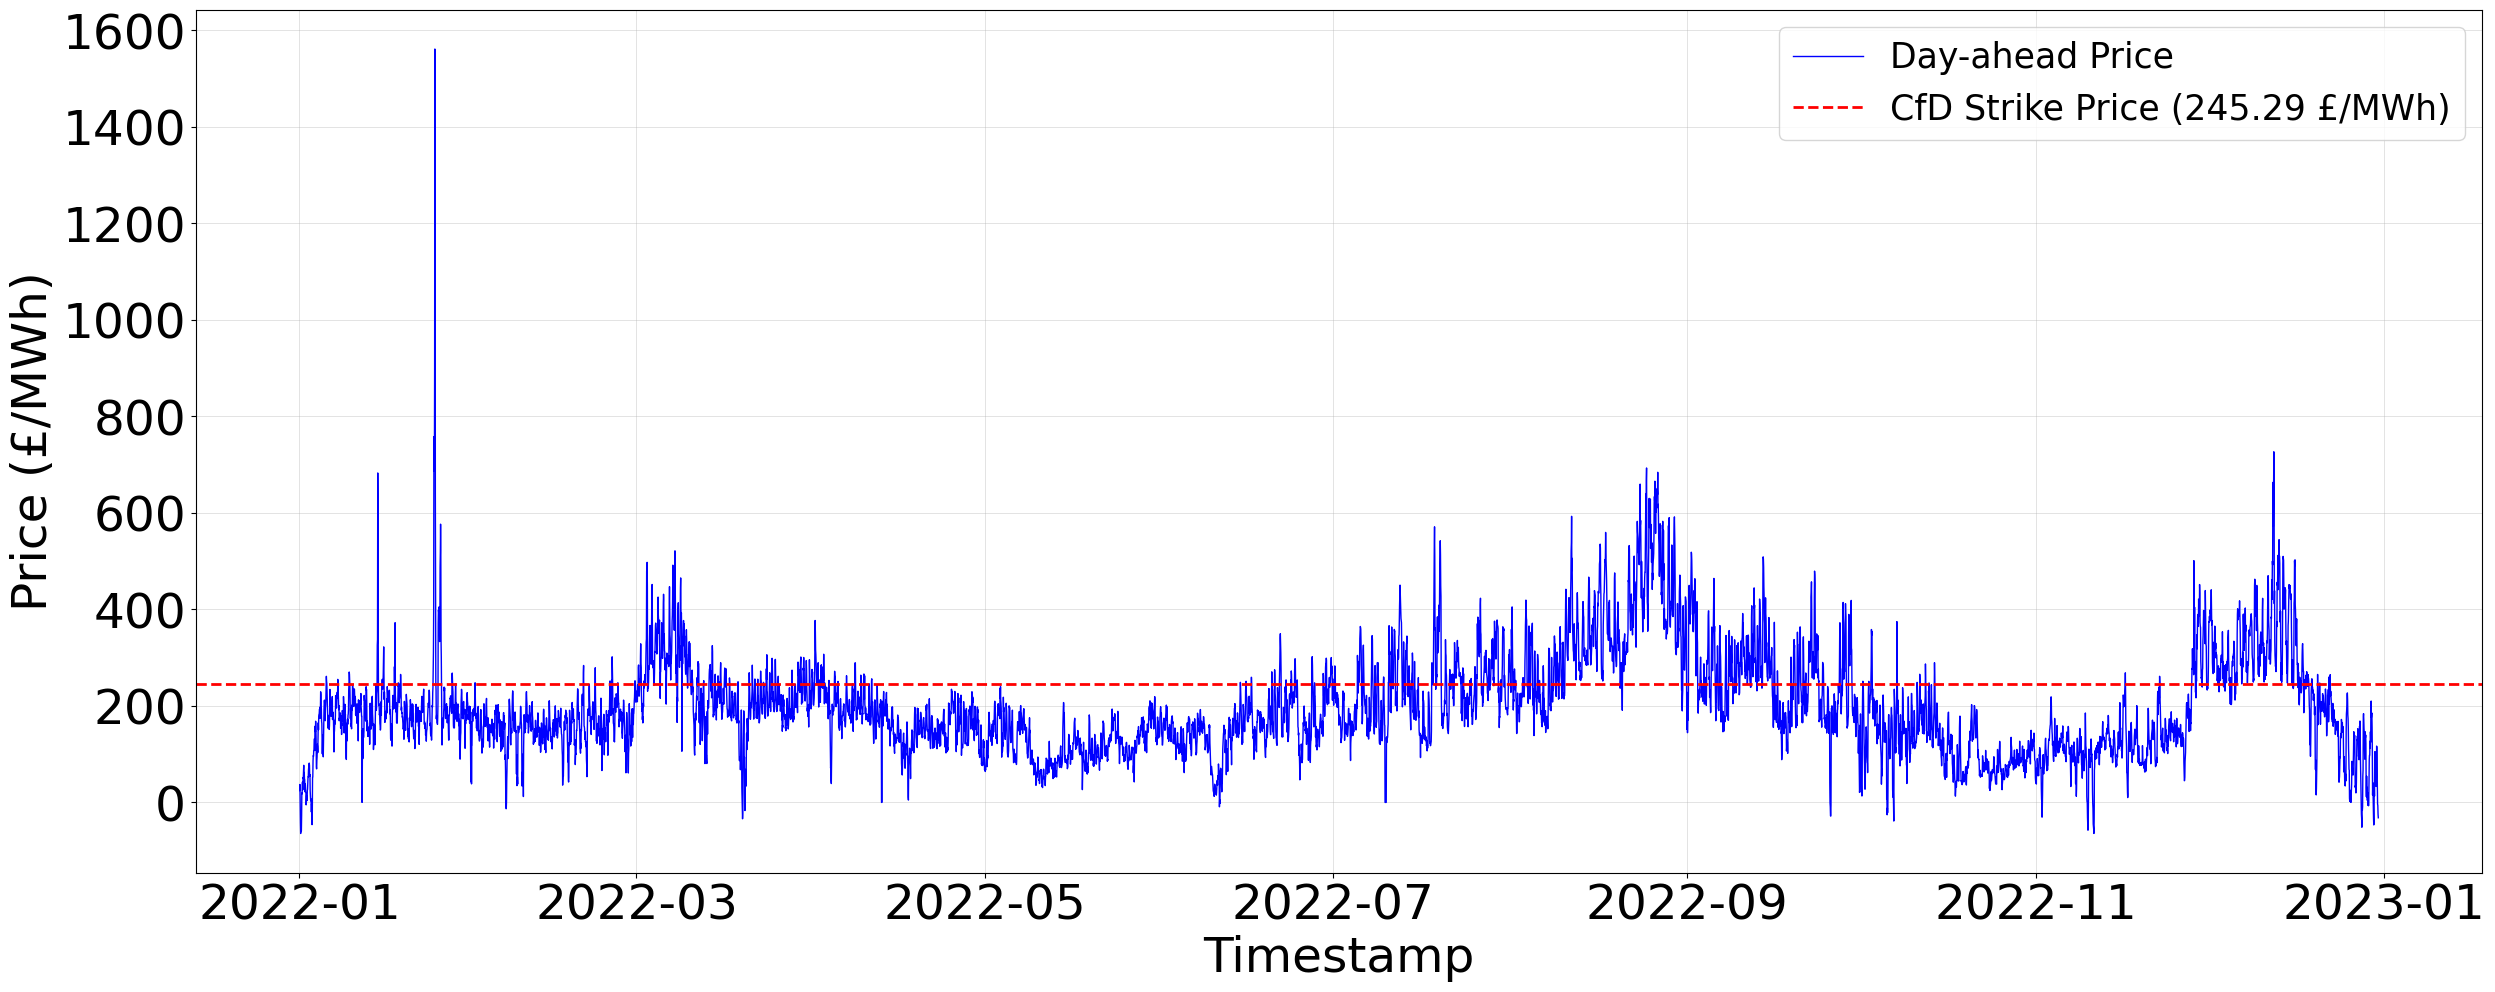

'/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/Market_Price_and_CfD_Price.png'

In [10]:
# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'

# Filter the data for the specified time range
filtered_data = results_df.loc[start_date:end_date]
filtered_market_prices = market_prices.loc[start_date:end_date]


# Plot Market Price and CfD
plt.figure(figsize=(25, 10))
plt.plot(filtered_market_prices.index, filtered_market_prices, label='Day-ahead Price', color='blue', linewidth=1, linestyle='-')
plt.axhline(y=245.29, color='red', linestyle='--', label='CfD Strike Price (245.29 £/MWh)', linewidth=2)
plt.xlabel('Timestamp', fontsize=35)
plt.ylabel('Price (£/MWh)', fontsize=35)
plt.legend(fontsize=25)
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.tight_layout(pad=1.0)

# Save the plot
output_path_plot = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/Market_Price_and_CfD_Price.png'
plt.savefig(output_path_plot, dpi=300)
plt.show()

output_path_plot


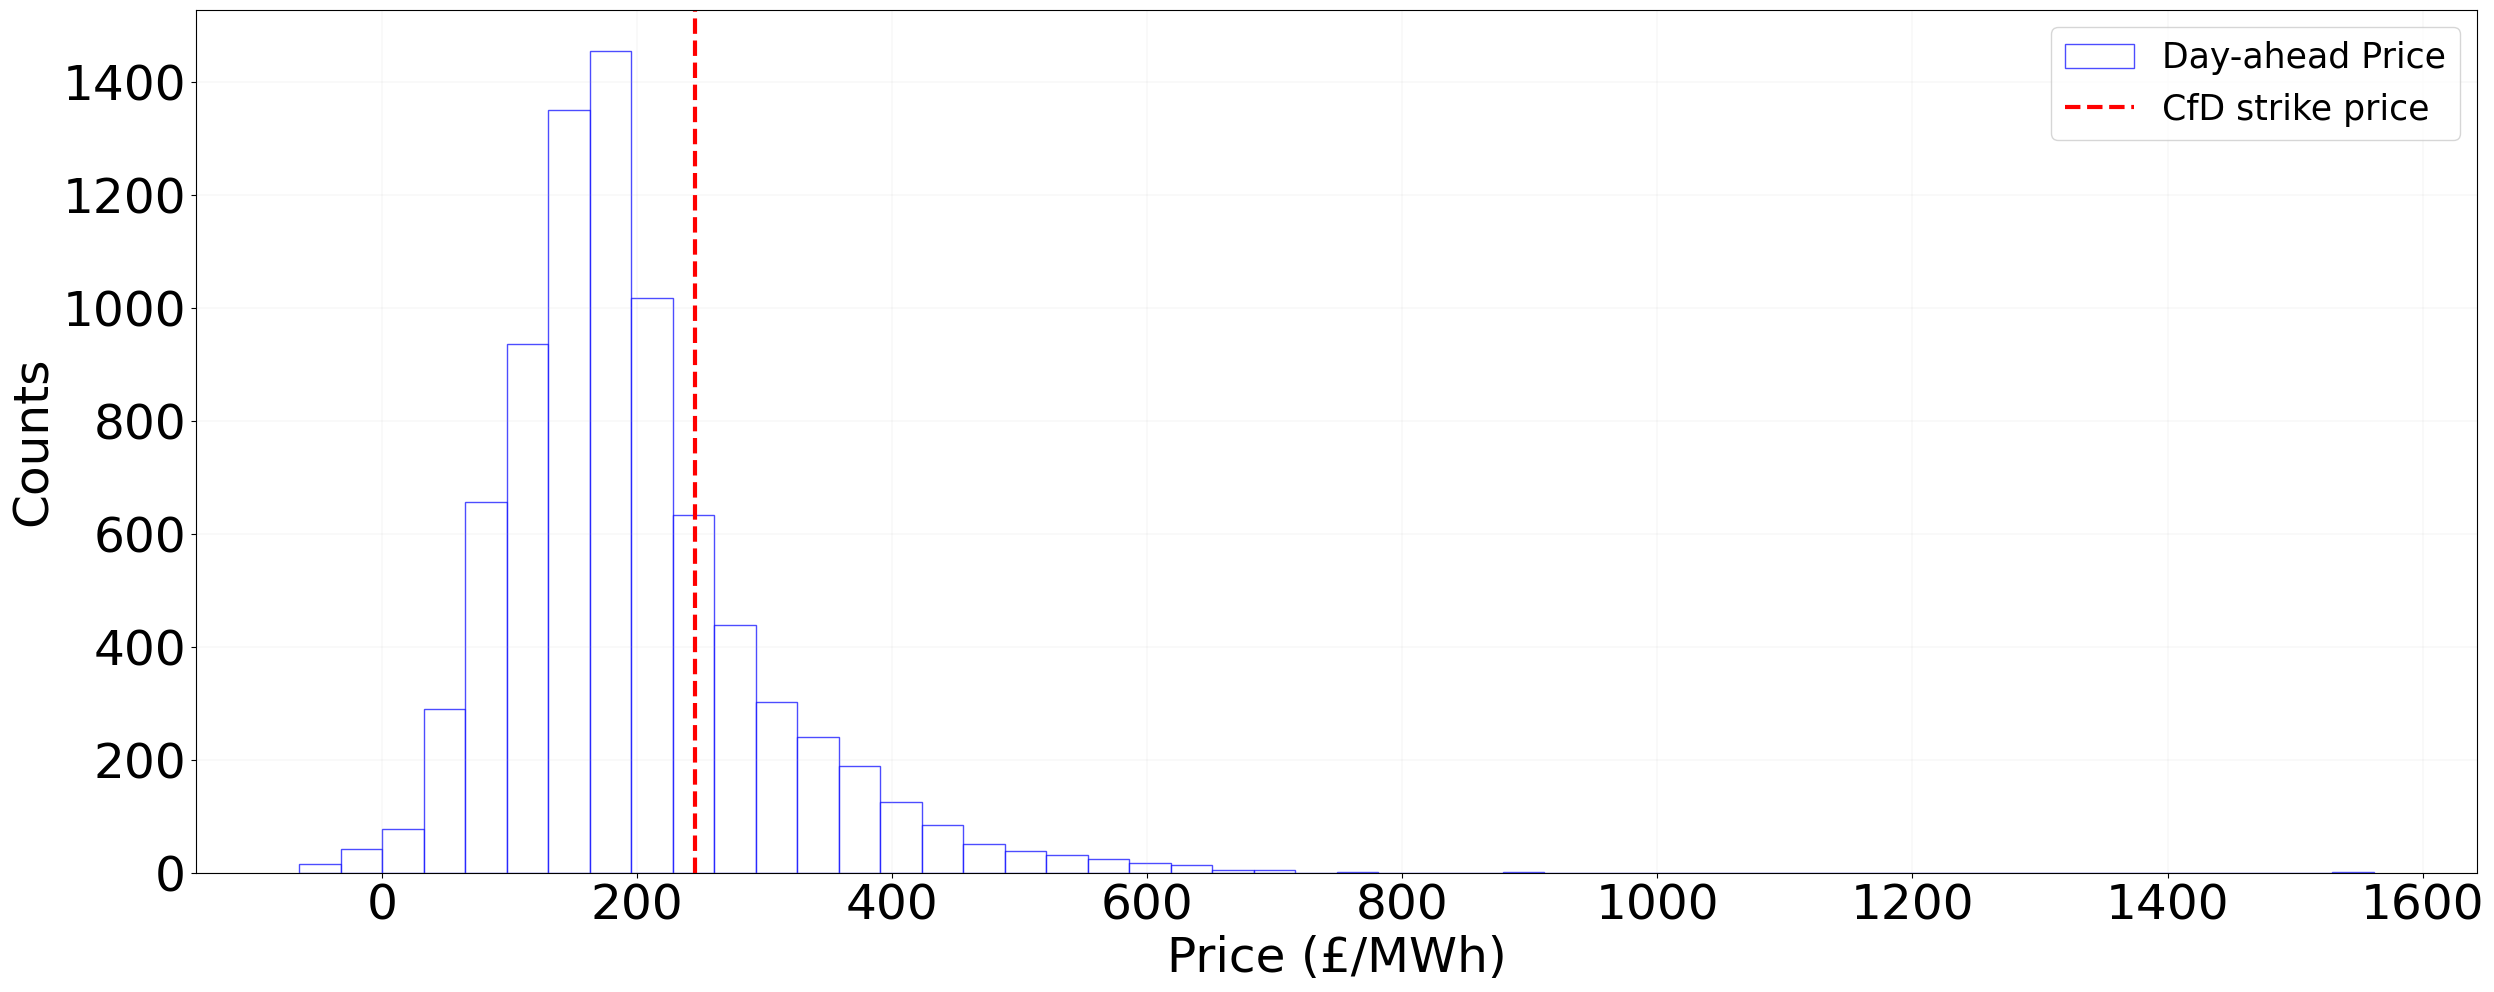

In [11]:
# Define the time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-01 23:00:00'

# Filter the data for the specified time range
filtered_market_prices = market_prices.loc[start_date:end_date]

# CfD strike price
cfd_strike_price = 245.29

# Plot histogram for Market Price and CfD
plt.figure(figsize=(25, 10))
plt.hist(filtered_market_prices, bins=50, alpha=0.7, label='Day-ahead Price', color='white', edgecolor='blue')
plt.axvline(x=cfd_strike_price, color='red', linestyle='--', label='CfD strike price', linewidth=3)
plt.xlabel('Price (£/MWh)', fontsize=35)
plt.ylabel('Counts', fontsize=35)
plt.legend(fontsize=25)
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.2)
plt.tight_layout()

# Increase the font size of the tick labels
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/market_price_histogram.png'
plt.savefig(output_plot_path, dpi=300)

# Display the plot
plt.show()


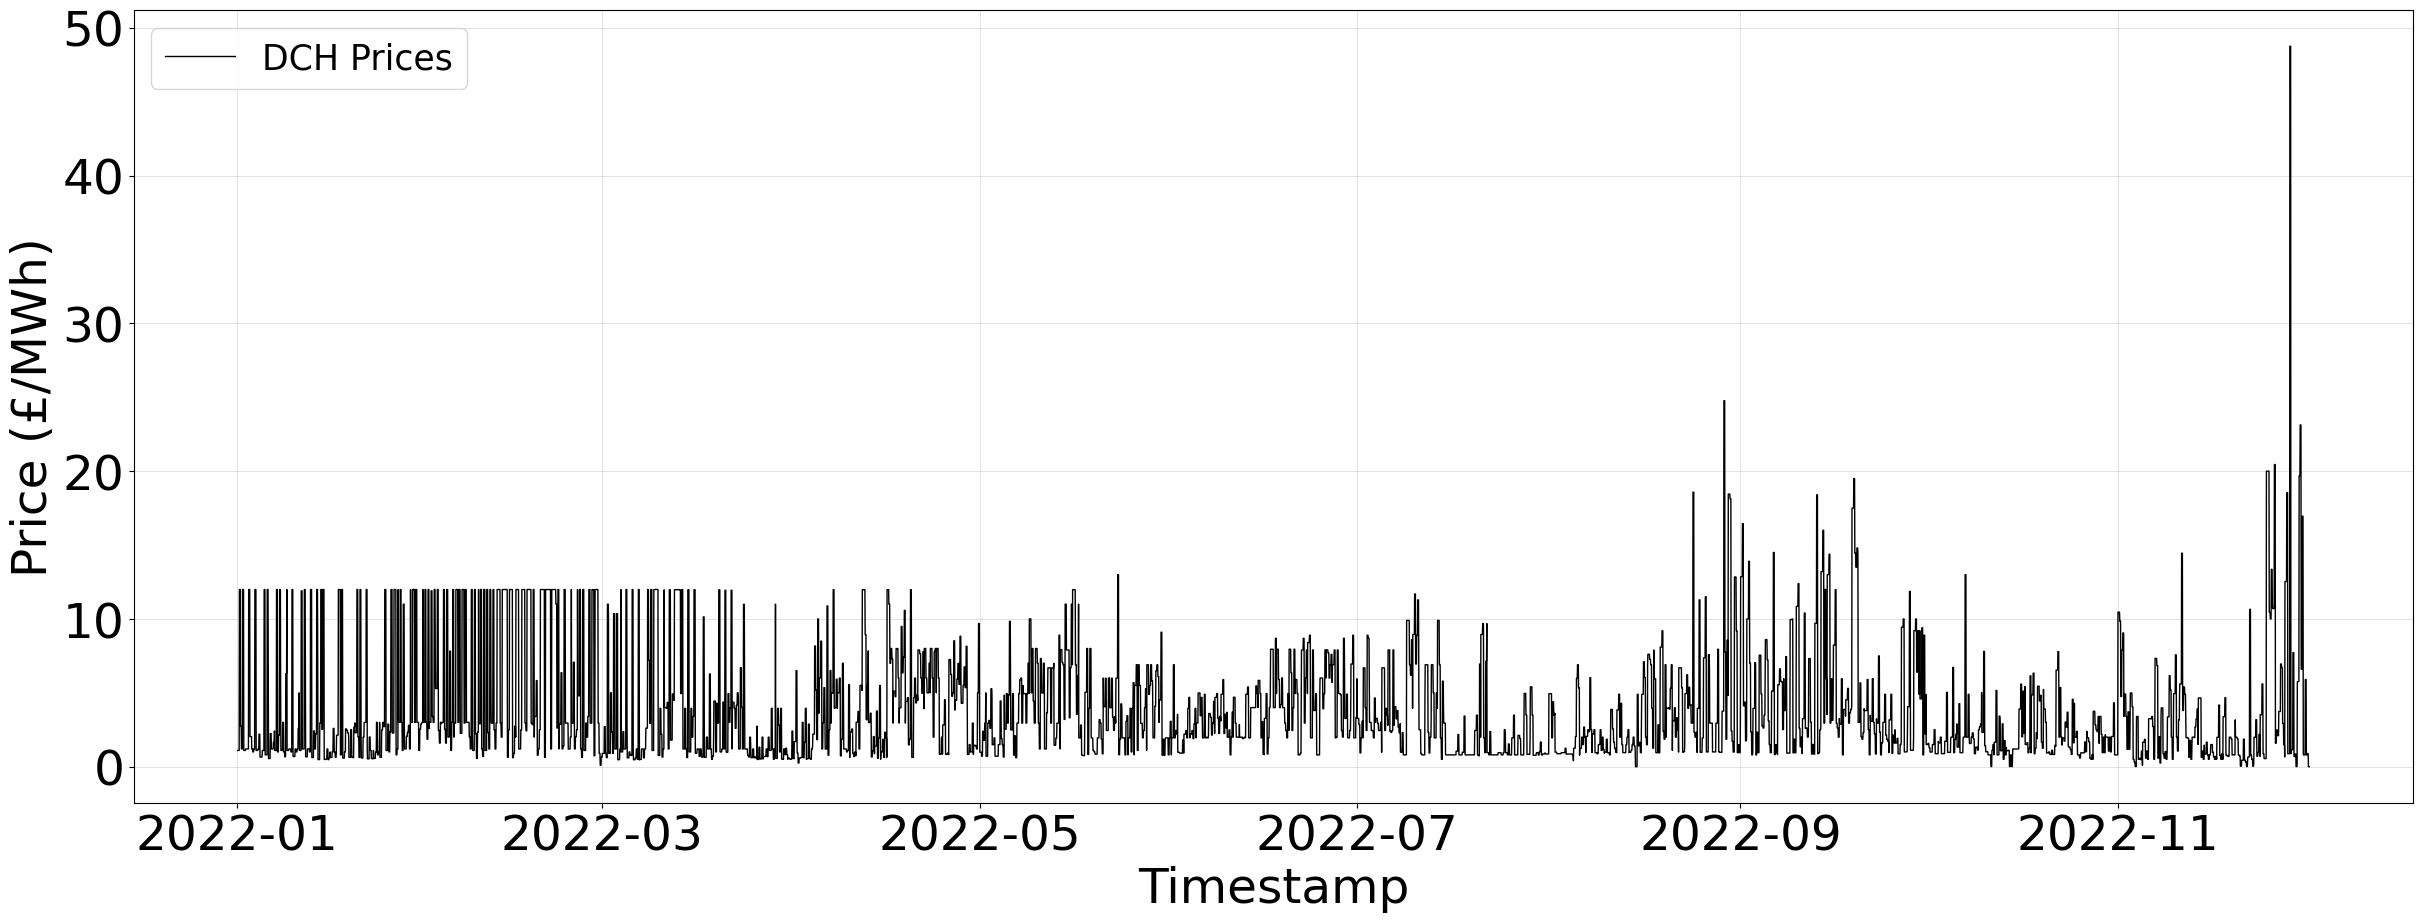

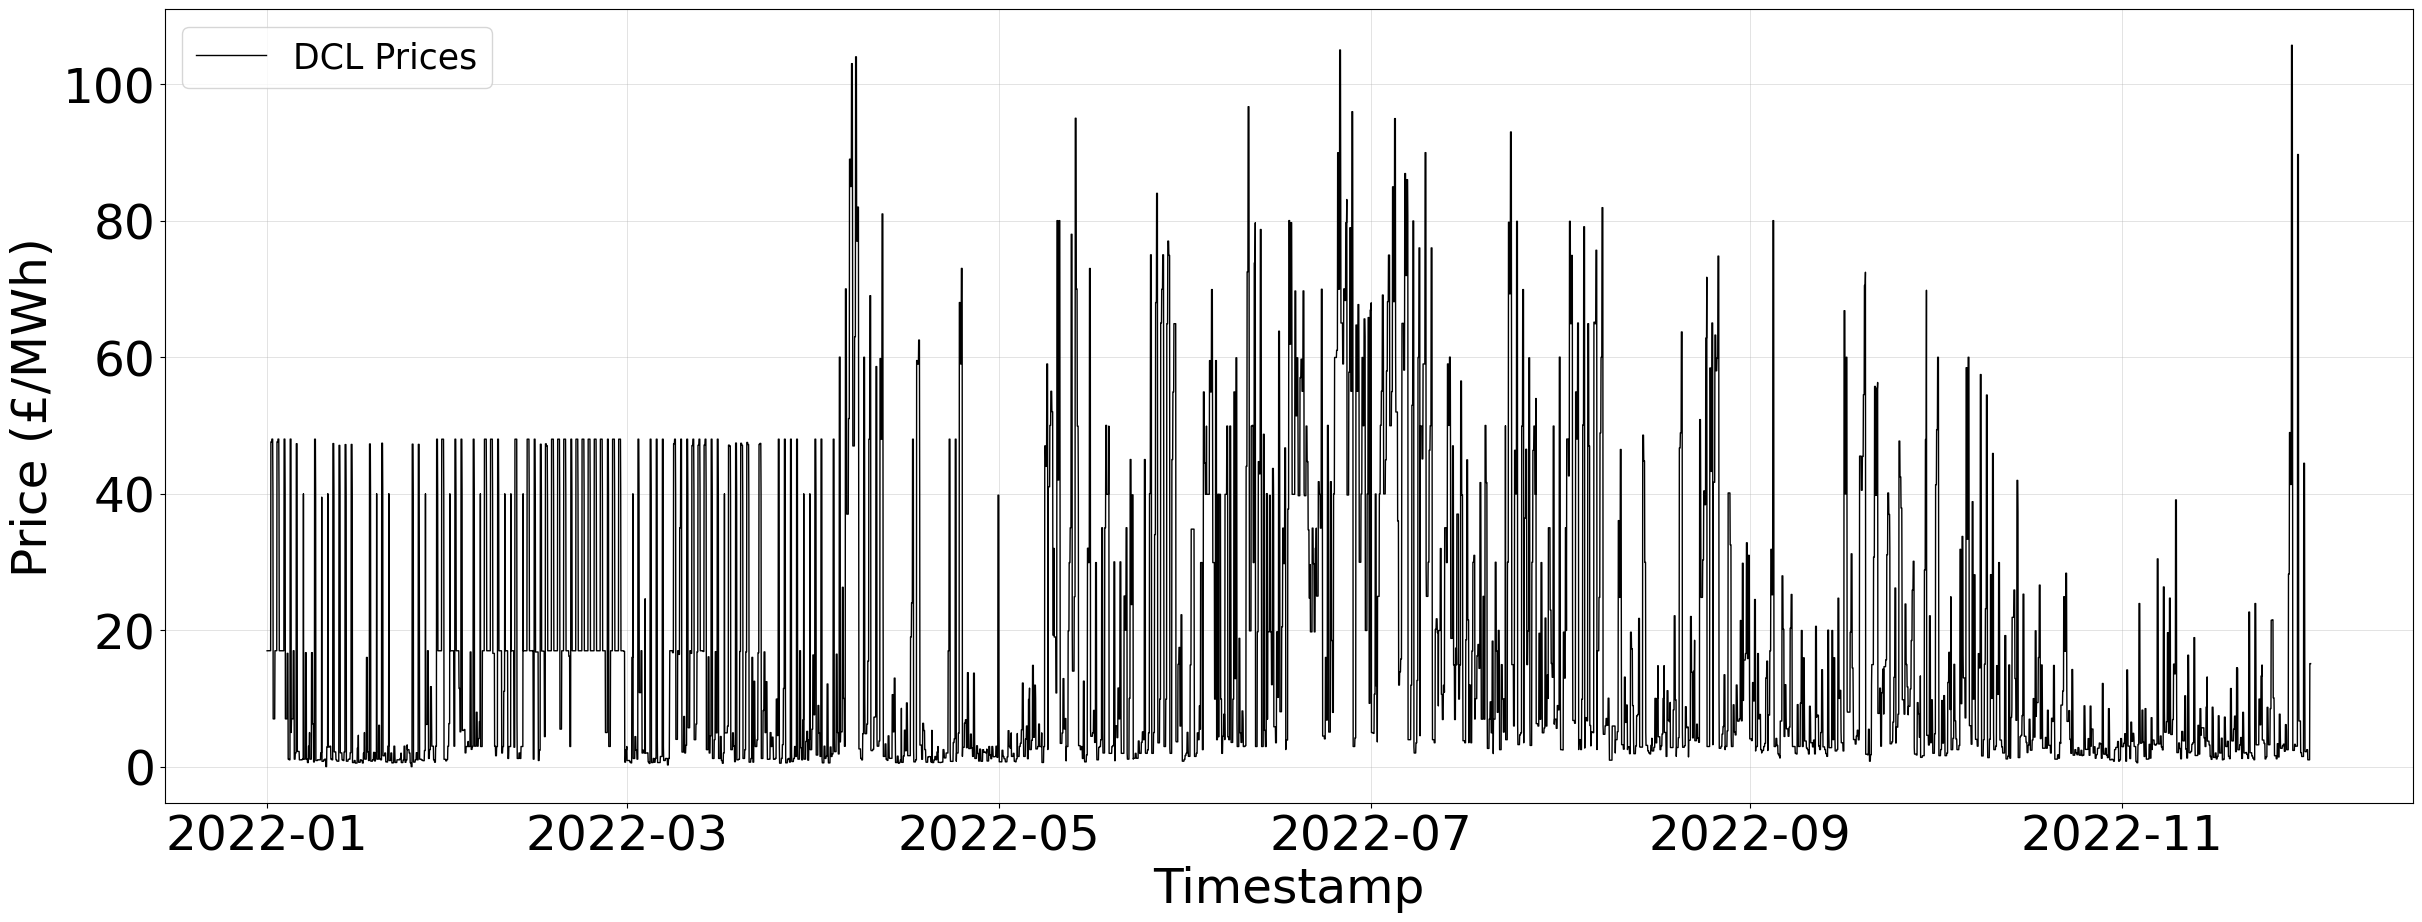

In [12]:
# Ensure 'Timestamp' is in datetime format
dch_prices.index = pd.to_datetime(dch_prices.index)
dcl_prices.index = pd.to_datetime(dcl_prices.index)

# Filter the data for the specified time range
start_date = '2022-01-01 00:00:00'
end_date = '2022-12-01 23:00:00'

filtered_dch_prices = dch_prices.loc[start_date:end_date]
filtered_dcl_prices = dcl_prices.loc[start_date:end_date]

# Set font sizes
plt.rcParams.update({'font.size': 35, 'axes.titlesize': 35, 'axes.labelsize': 35, 'xtick.labelsize': 35, 'ytick.labelsize': 35, 'legend.fontsize': 25})

# Plot DCH prices over time
plt.figure(figsize=(25, 10))
plt.plot(filtered_dch_prices.index, filtered_dch_prices.values, label='DCH Prices', color='k', linewidth=1, linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Price (£/MWh)')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.tight_layout(pad=1.0)

# Save the DCH plot
dch_output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/DCH_Prices_Plot.png'
plt.savefig(dch_output_path, dpi=300)

# Show the DCH plot
plt.show()

# Plot DCL prices over time
plt.figure(figsize=(25, 10))
plt.plot(filtered_dcl_prices.index, filtered_dcl_prices.values, label='DCL Prices', color='k', linewidth=1, linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Price (£/MWh)')
plt.legend()
plt.grid(True, linestyle='-', alpha=0.5, linewidth=0.5)
plt.tight_layout()
plt.tight_layout(pad=1.0)


# Save the DCL plot
dcl_output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Input Plots/DCL_Prices_Plot.png'
plt.savefig(dcl_output_path, dpi=300)

# Show the DCL plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery Charging Status Plot_Day_ahead_v2.png


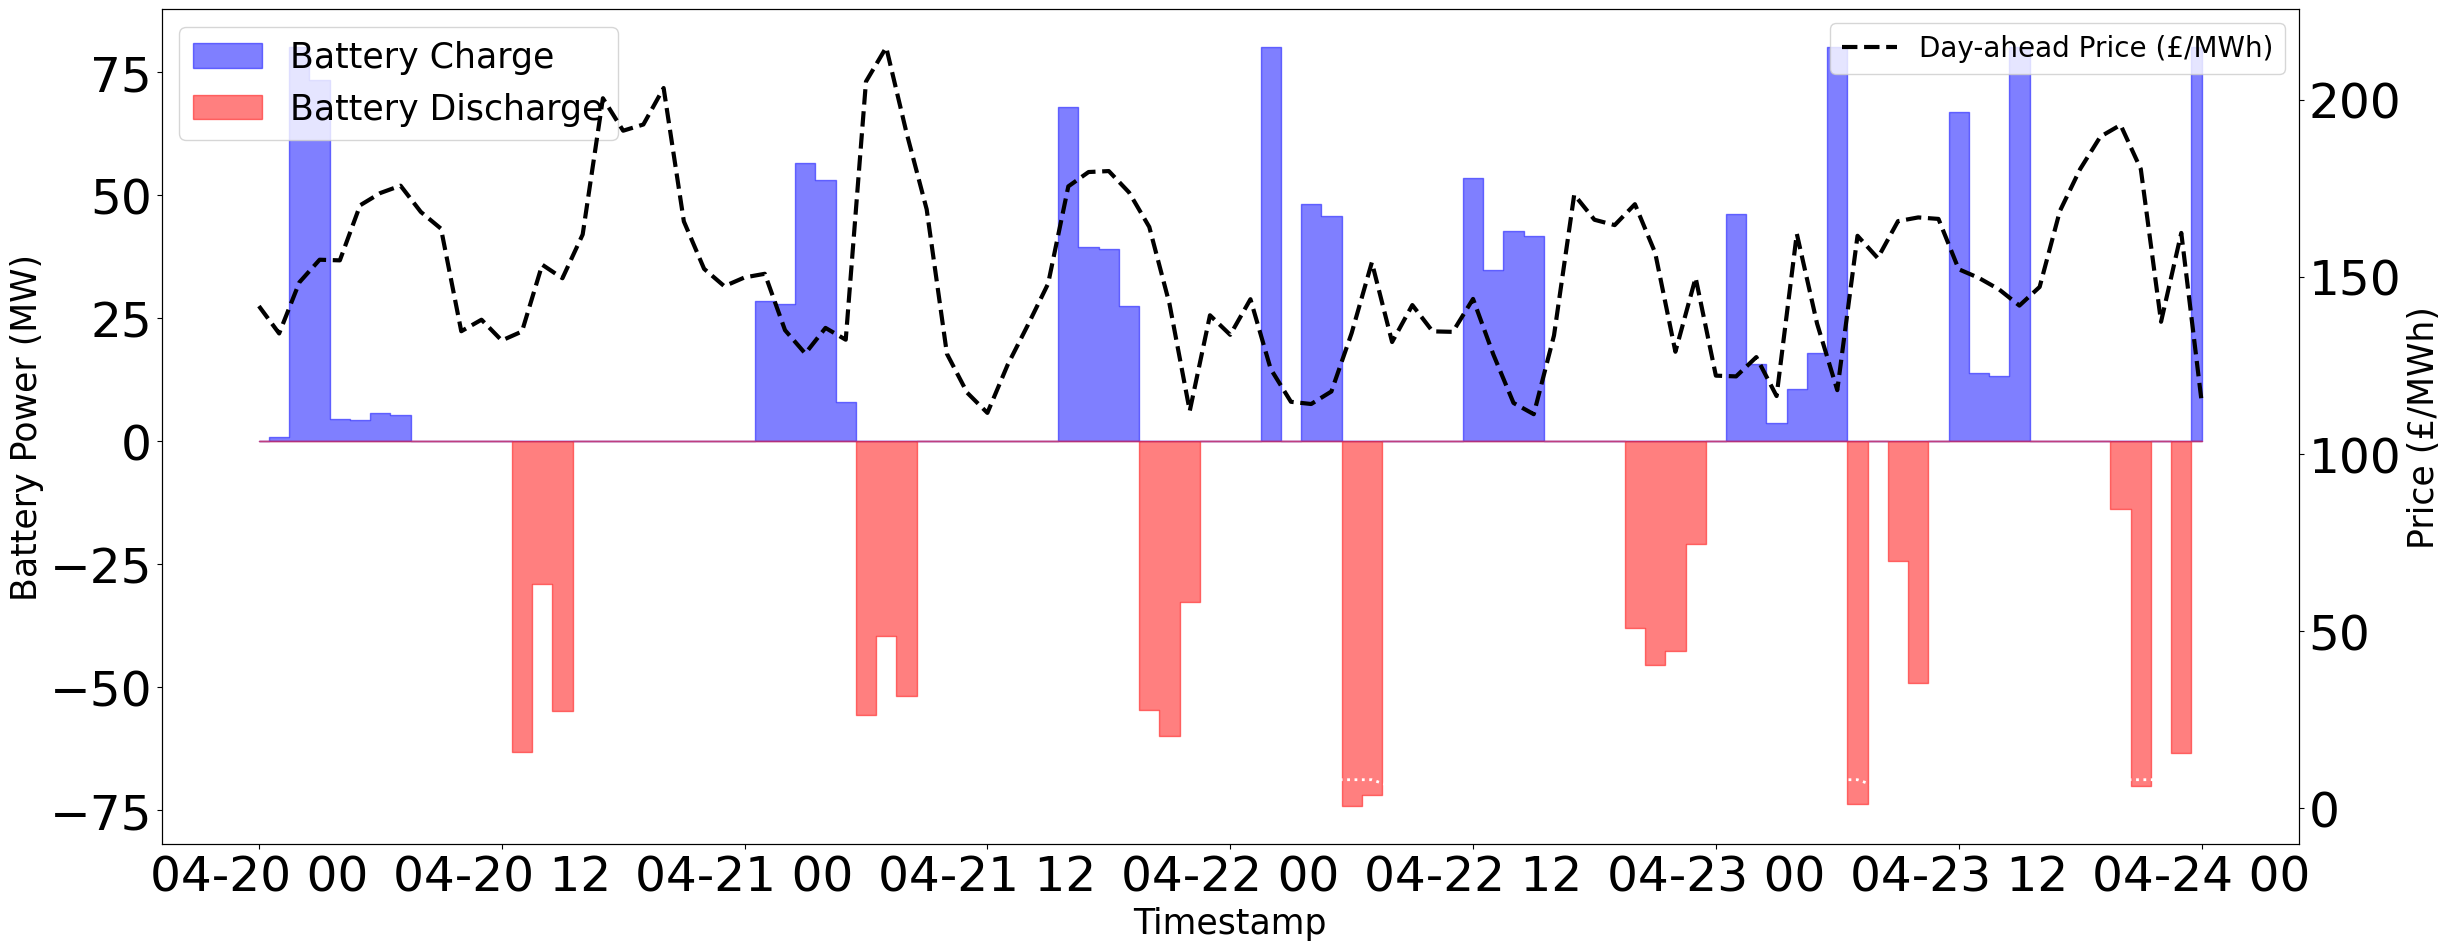

In [13]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]

# Extract relevant columns
timestamp = filtered_data['Timestamp']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
market_price = filtered_data['Market Price (£/MWh)']
dch_price = filtered_data['DCH Price (£/MWh)']
dcl_price = filtered_data['DCL Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Set font sizes
plt.rcParams.update({'font.size': 25})  # Global font size

# Plot battery charge and discharge as area plots on the left Y-axis
ax1.fill_between(timestamp, battery_store, label='Battery Charge', color='blue', step="mid", alpha=0.5)
ax1.fill_between(timestamp, -battery_dispatch, label='Battery Discharge', color='red', step="mid", alpha=0.5)
ax1.set_xlabel('Timestamp', fontsize=25)
ax1.set_ylabel('Battery Power (MW)', fontsize=25)
ax1.legend(loc='upper left', fontsize=25)

# Create a second Y-axis for market, DCL, and DCH prices
ax2 = ax1.twinx()
ax2.plot(timestamp, market_price, label='Day-ahead Price (£/MWh)', color='black', linestyle='--', linewidth=3)
ax2.plot(timestamp, dch_price, label='', color='w', linestyle=':', linewidth=2)

ax2.set_ylabel('Price (£/MWh)', fontsize=25)
ax2.legend(loc='upper right', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery Charging Status Plot_Day_ahead_v2.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery Charging Status Plot.png


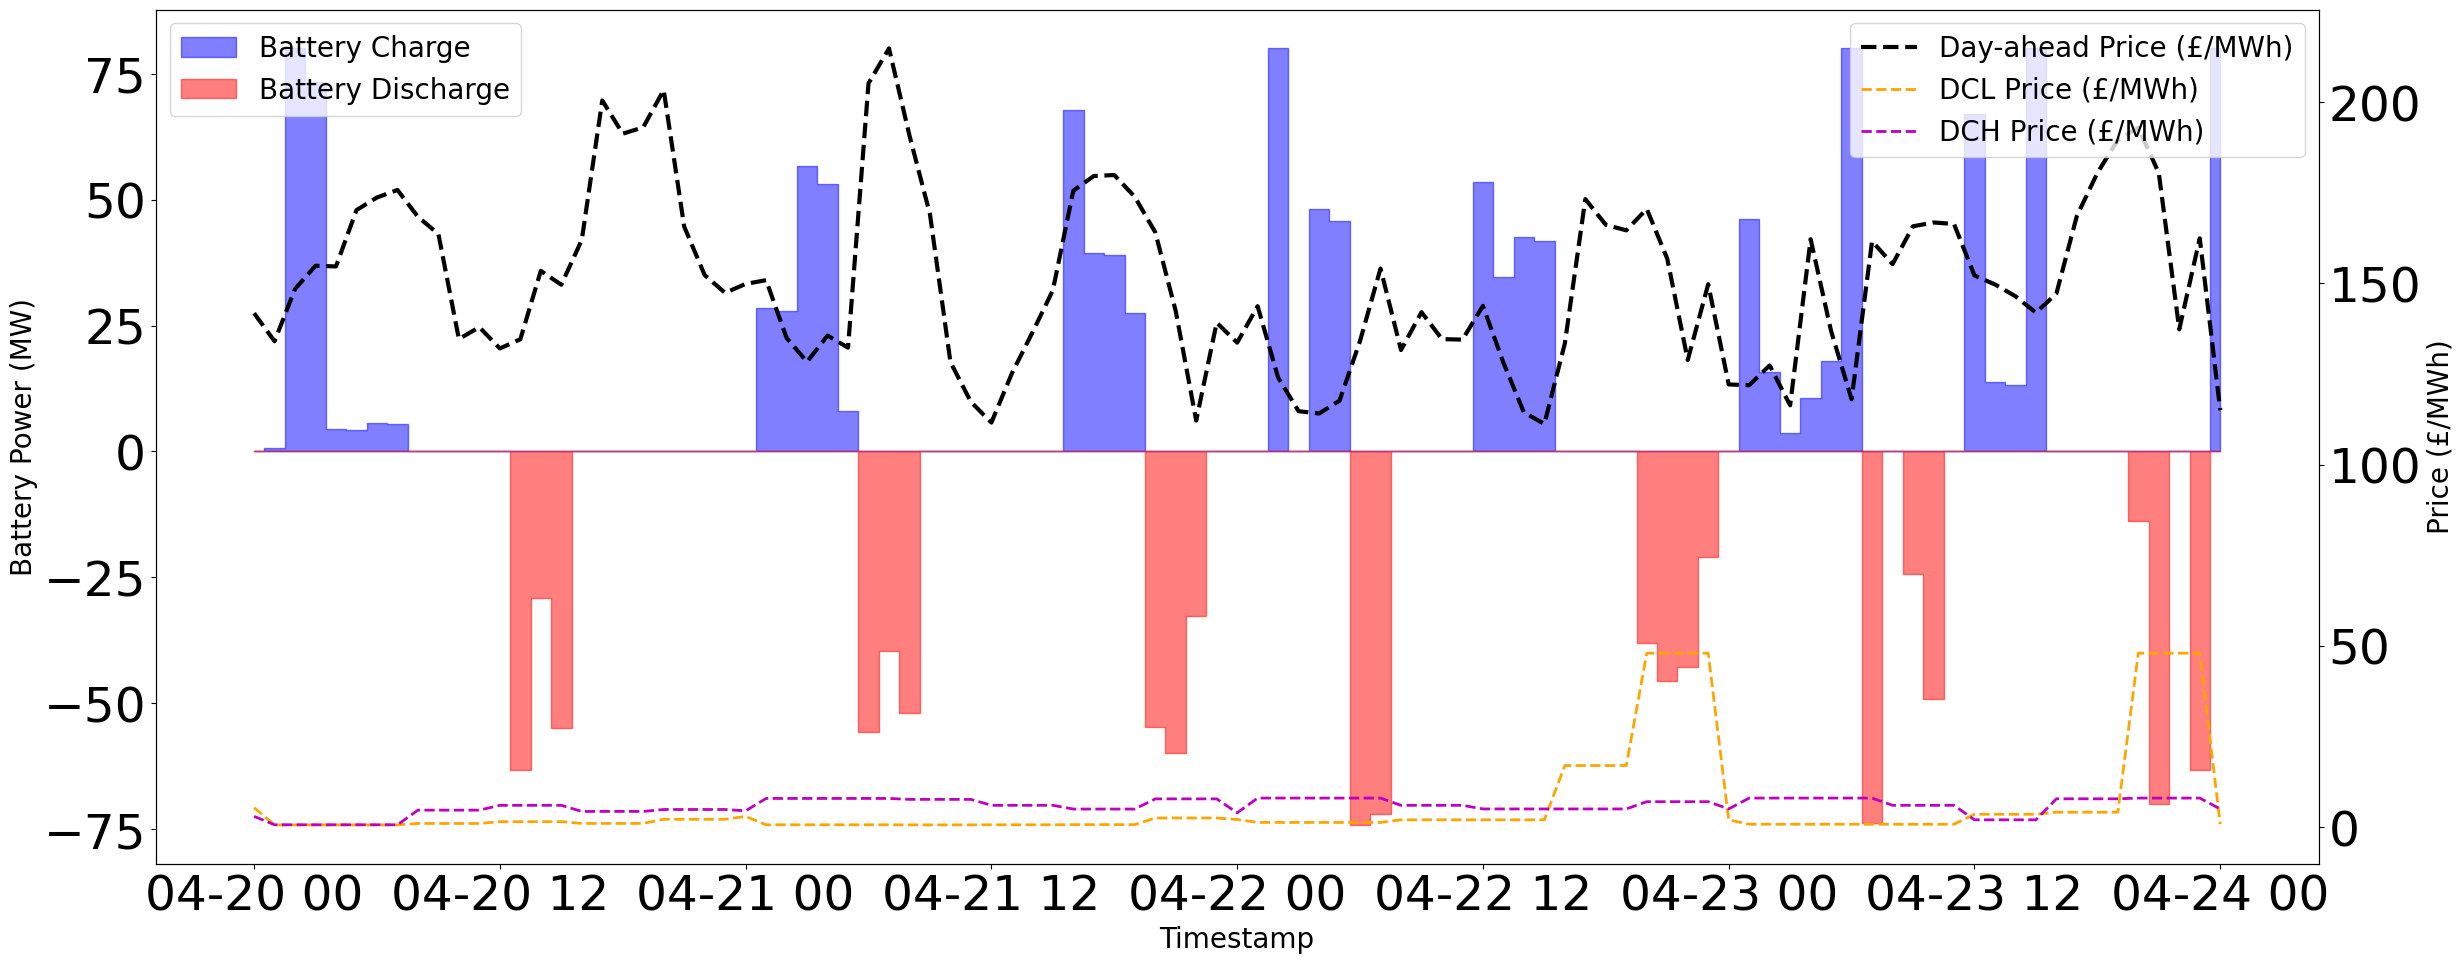

In [14]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]

# Extract relevant columns
timestamp = filtered_data['Timestamp']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
market_price = filtered_data['Market Price (£/MWh)']
dch_price = filtered_data['DCH Price (£/MWh)']
dcl_price = filtered_data['DCL Price (£/MWh)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Set font sizes
plt.rcParams.update({'font.size': 20})  # Global font size

# Plot battery charge and discharge as area plots on the left Y-axis
ax1.fill_between(timestamp, battery_store, label='Battery Charge', color='blue', step="mid", alpha=0.5)
ax1.fill_between(timestamp, -battery_dispatch, label='Battery Discharge', color='red', step="mid", alpha=0.5)
ax1.set_xlabel('Timestamp', fontsize=20)
ax1.set_ylabel('Battery Power (MW)', fontsize=20)
ax1.legend(loc='upper left', fontsize=20)

# Create a second Y-axis for market, DCL, and DCH prices
ax2 = ax1.twinx()
ax2.plot(timestamp, market_price, label='Day-ahead Price (£/MWh)', color='black', linestyle='--', linewidth=3)
ax2.plot(timestamp, dcl_price, label='DCL Price (£/MWh)', color='orange', linestyle='--', linewidth=2)
ax2.plot(timestamp, dch_price, label='DCH Price (£/MWh)', color='m', linestyle='--', linewidth=2)

ax2.set_ylabel('Price (£/MWh)', fontsize=20)
ax2.legend(loc='upper right', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery Charging Status Plot.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Battery Charging Pattern.png


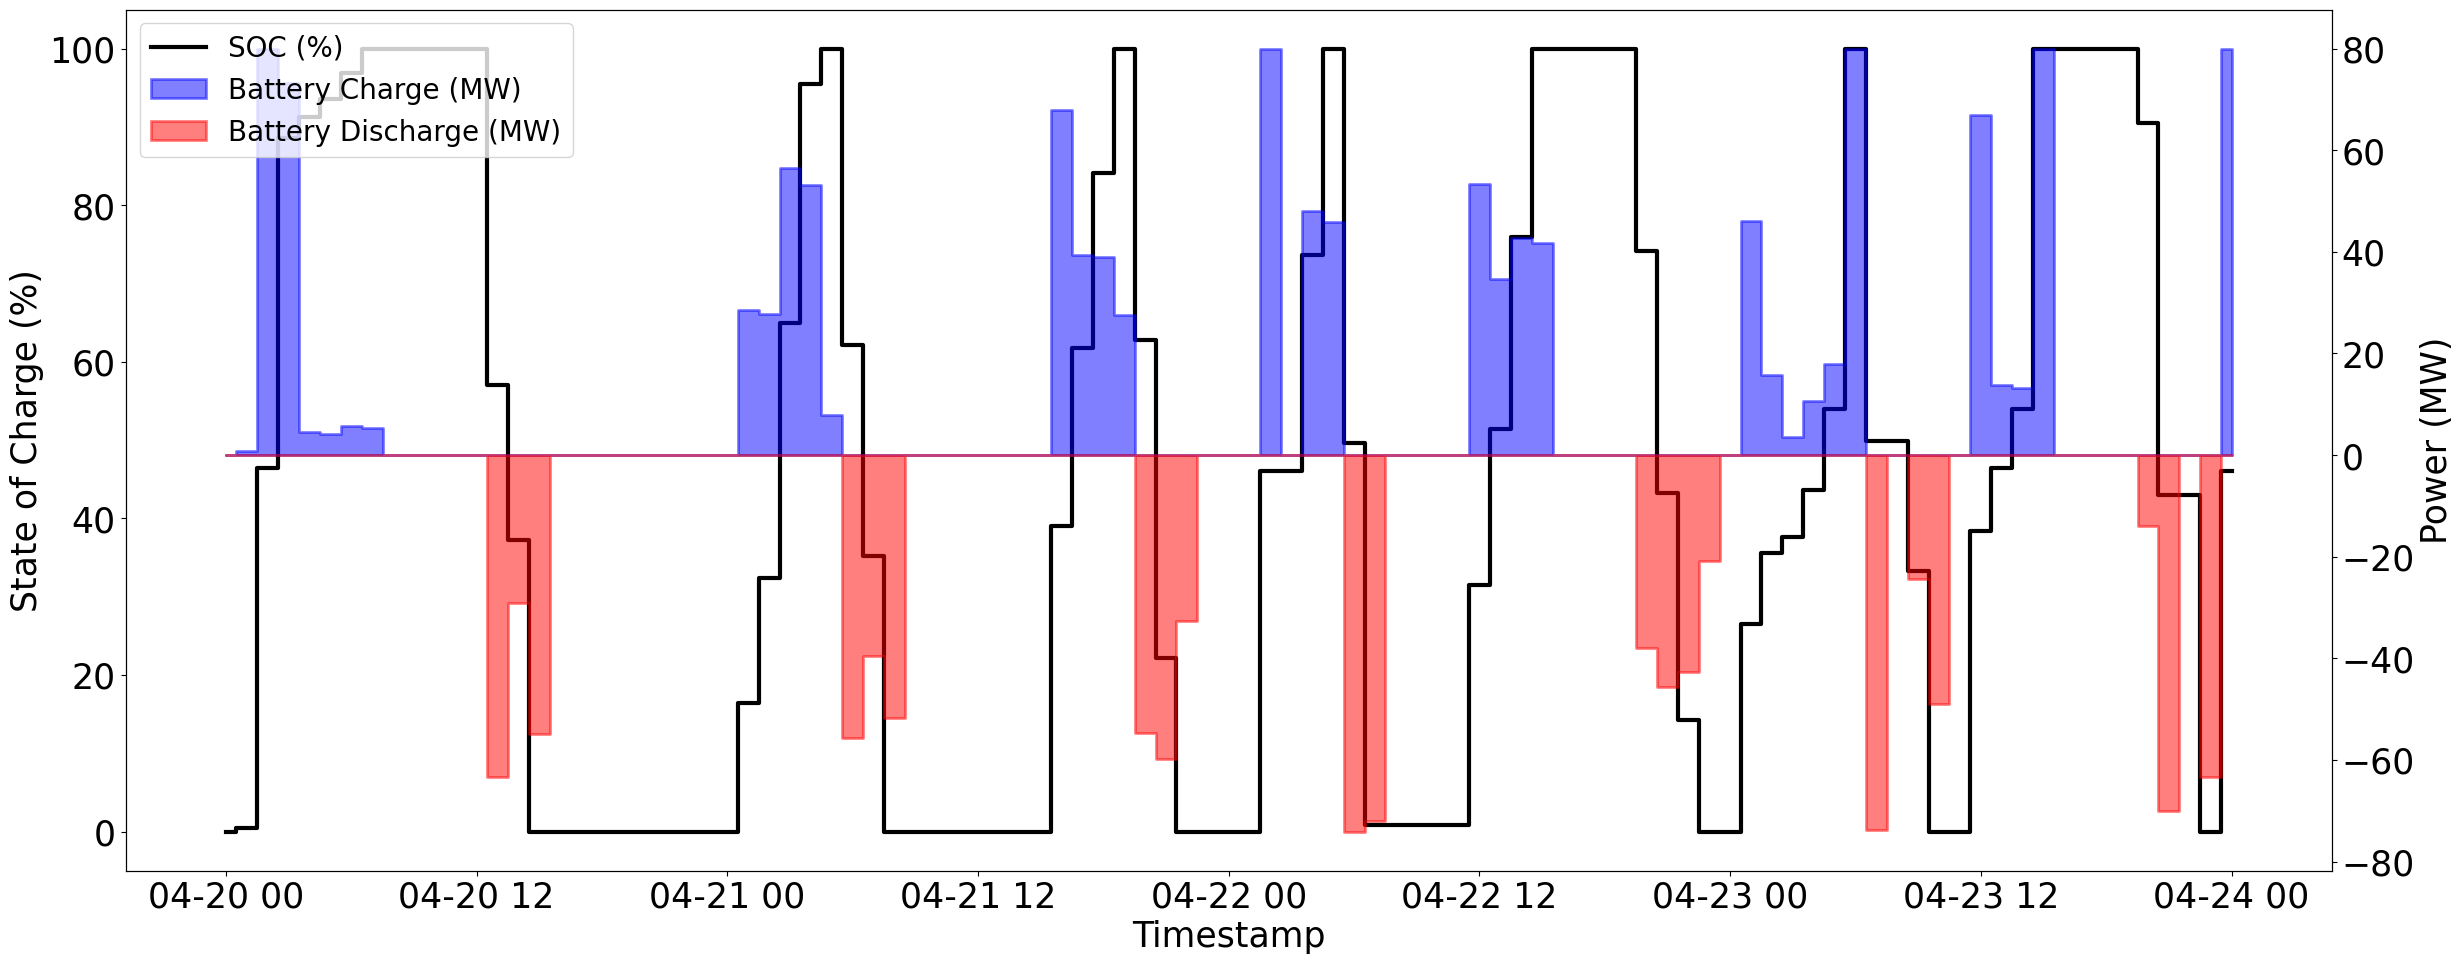

In [15]:
# Load the data from the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'

# Filter data for the specified date range
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]

# Extract relevant columns
timestamp = filtered_data['Timestamp']
battery_store = filtered_data['Battery Store (MW)']
battery_dispatch = filtered_data['Battery Dispatch (MW)']
soc_percentage = filtered_data['State of Charge (%)']
wind_generation = filtered_data['Wind Generation (MW)']

# Plot the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot SOC% on the left Y-axis in step pattern
ax1.step(timestamp, soc_percentage, label='SOC (%)', color='k', linestyle='-', linewidth=3, where='mid')
ax1.set_xlabel('Timestamp', fontsize=25)
ax1.set_ylabel('State of Charge (%)', color='k', fontsize=25)
ax1.tick_params(axis='y', labelcolor='k', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)

# Create a second Y-axis for wind energy and battery charge/discharge
ax2 = ax1.twinx()
ax2.fill_between(timestamp, battery_store, label='Battery Charge (MW)', color='blue', linewidth=2, step="mid", alpha=0.5)
ax2.fill_between(timestamp, -battery_dispatch, label='Battery Discharge (MW)', color='red', linewidth=2, step="mid", alpha=0.5)
ax2.set_ylabel('Power (MW)', fontsize=25)
ax2.tick_params(axis='y', labelsize=25)

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot as a high-resolution image
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Battery Charging Pattern.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {output_image_path}")

# Show plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Market Price Plot.png


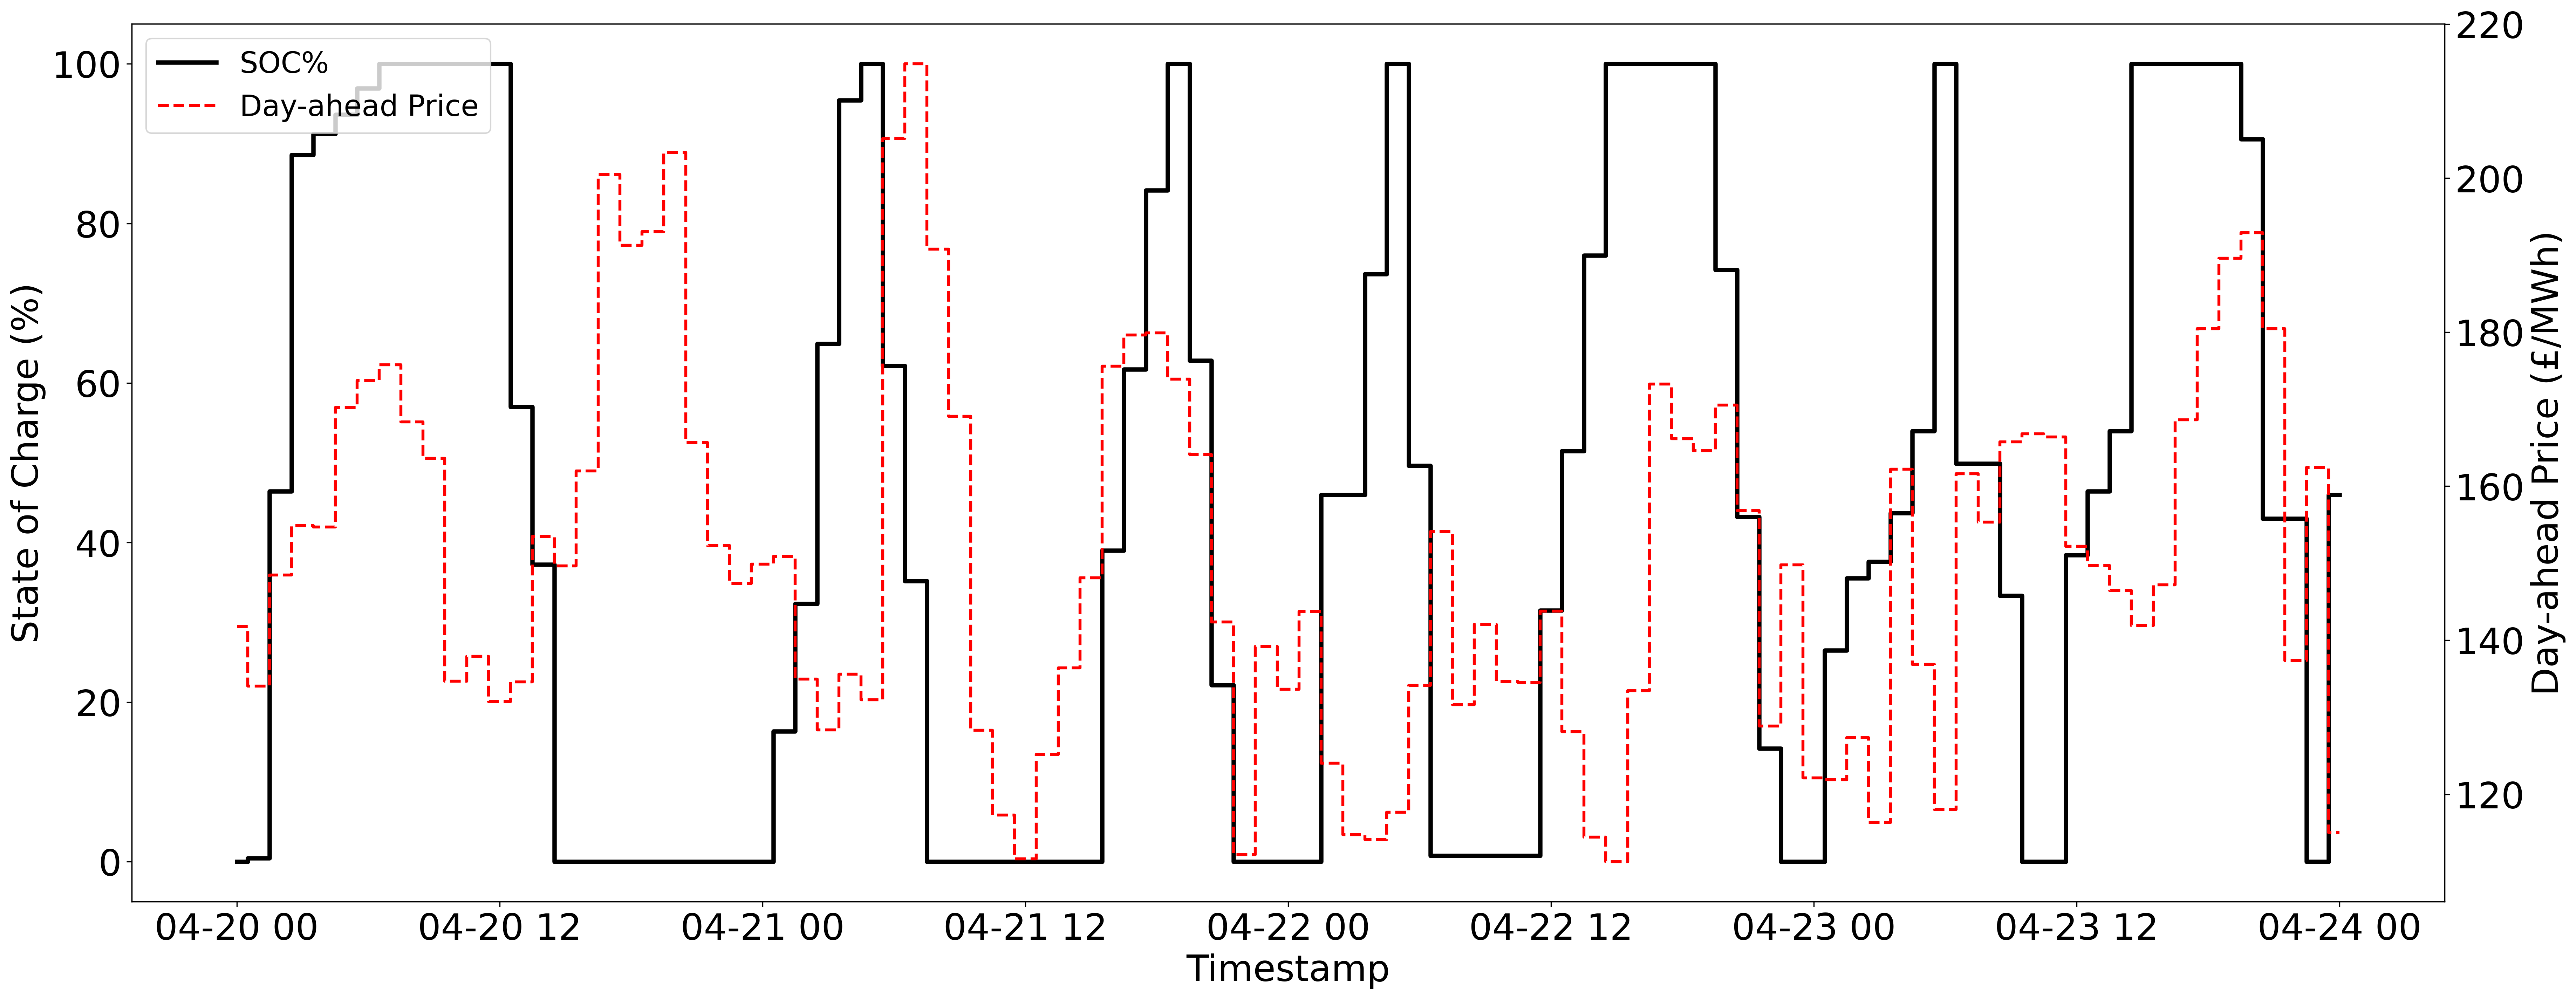

In [16]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
results_df = pd.read_excel(file_path, parse_dates=['Timestamp'])
results_df.set_index('Timestamp', inplace=True)

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
filtered_df = results_df.loc[start_date:end_date]

# Set font sizes
plt.rcParams.update({
    'font.size': 25,           # Global font size
    'axes.titlesize': 25,      # Title font size
    'axes.labelsize': 25,      # X and Y label size
    'xtick.labelsize': 25,     # X tick label size
    'ytick.labelsize': 25,     # Y tick label size
    'legend.fontsize': 20,     # Legend font size
})

# Plot SOC% and Market Price
fig, ax1 = plt.subplots(figsize=(25, 10), dpi=300)

ax1.step(filtered_df.index, filtered_df['State of Charge (%)'], where='mid', label='SOC%', linewidth=3, color='k')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('State of Charge (%)', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()
ax2.step(filtered_df.index, filtered_df['Market Price (£/MWh)'], where='mid', label='Day-ahead Price', linewidth=2, linestyle='--', color='r')
ax2.set_ylabel('Day-ahead Price (£/MWh)', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Add a single legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout(pad=1.0)

# Save the plot
output_plot_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Market Price Plot.png'
plt.savefig(output_plot_path, bbox_inches='tight', dpi=300)
print(f"Plot saved to {output_plot_path}")

# Show the plot
plt.show()


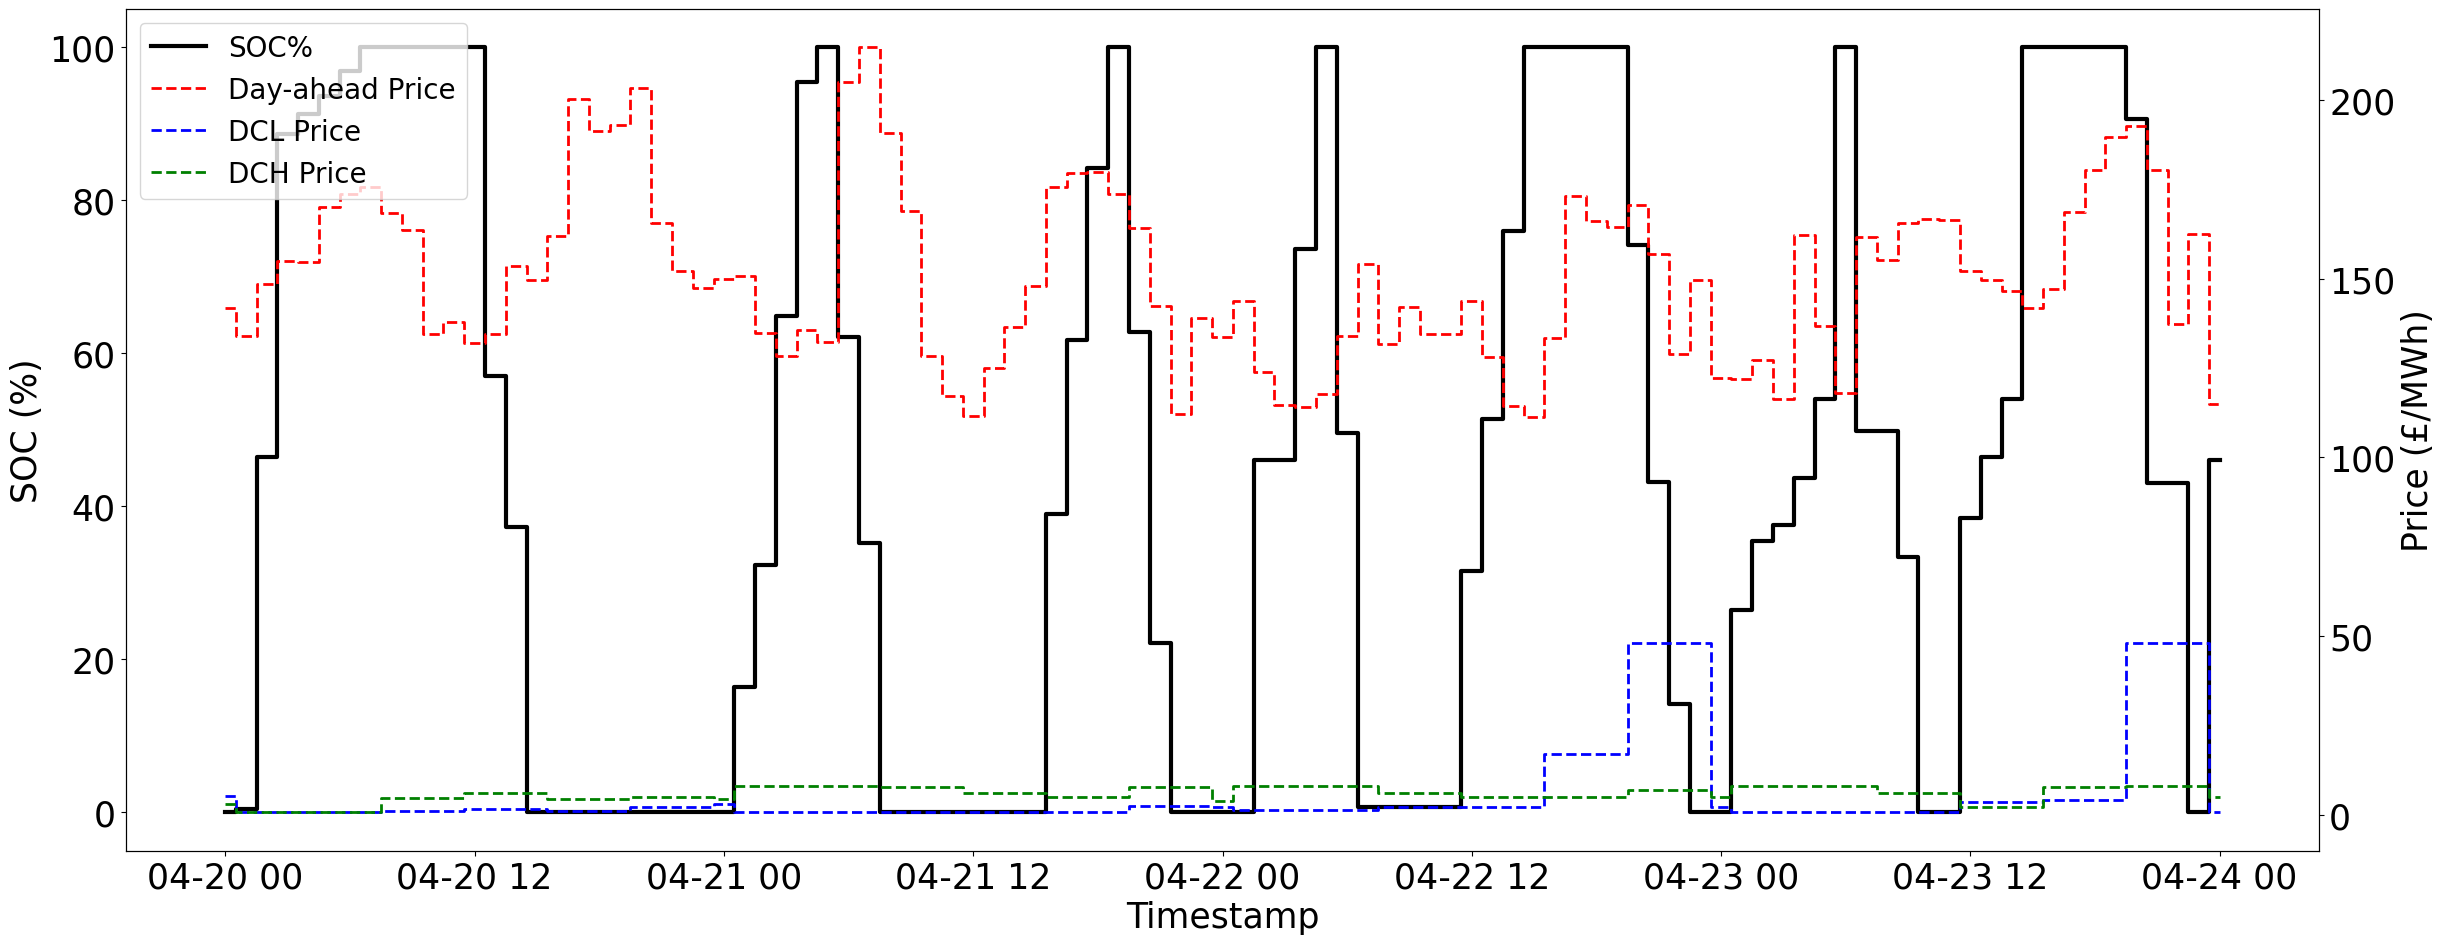

Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Prices Plot.png


In [17]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_two_buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
plot_data = data.loc[start_date:end_date]

# Set font sizes
plt.rcParams.update({'font.size': 25})  # You can change the number to adjust the font size

# Create the plot
fig, ax1 = plt.subplots(figsize=(25, 10))

# Plot SOC%
ax1.step(plot_data.index, plot_data['State of Charge (%)'], where='mid', label='SOC%', linewidth=3, color='k')
ax1.set_xlabel('Timestamp', fontsize=25)
ax1.set_ylabel('SOC (%)', color='k', fontsize=25)
ax1.tick_params(axis='y', labelcolor='k', labelsize=25)
ax1.tick_params(axis='x', labelsize=25)

# Create a second y-axis for the prices
ax2 = ax1.twinx()
ax2.step(plot_data.index, plot_data['Market Price (£/MWh)'], where='mid', label='Day-ahead Price', linewidth=2, linestyle='--', color='r')
ax2.step(plot_data.index, plot_data['DCL Price (£/MWh)'], where='mid', label='DCL Price', linewidth=2, linestyle='--', color='b')
ax2.step(plot_data.index, plot_data['DCH Price (£/MWh)'], where='mid', label='DCH Price', linewidth=2, linestyle='--', color='g')
ax2.set_ylabel('Price (£/MWh)', color='black', fontsize=25)
ax2.tick_params(axis='y', labelcolor='black', labelsize=25)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=20)
plt.tight_layout(pad=1.0)

# Save the plot in high resolution
output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/SOC and Prices Plot.png'
plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()
print(f"Plot saved to {output_path}")


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery_Revenue_Streams_Two_Buses.png


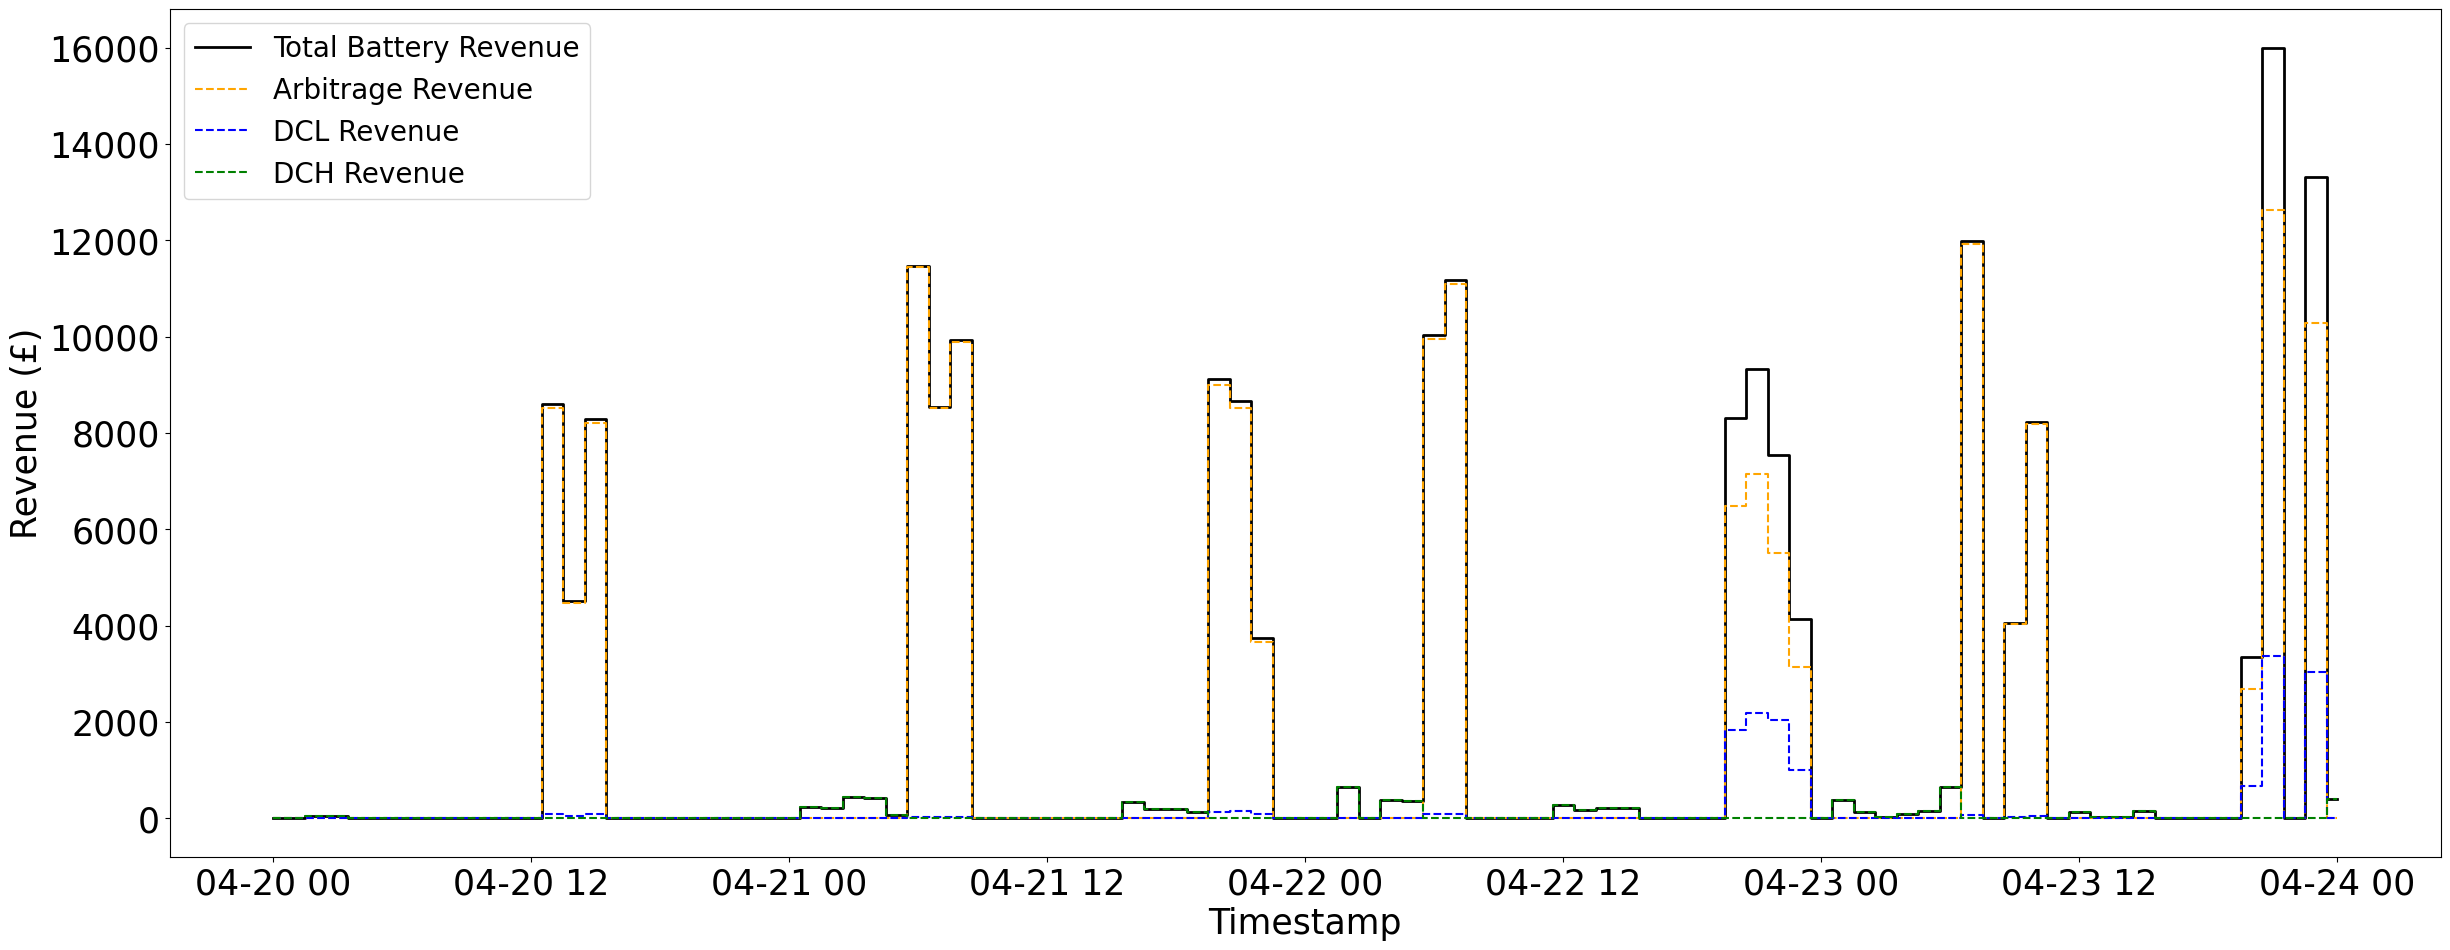

In [18]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
mask = (data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)
filtered_data = data.loc[mask]

# Set font sizes
plt.rcParams.update({
    'font.size': 25,         # General font size
    'axes.labelsize': 25,    # X and Y label font size
    'xtick.labelsize': 25,   # X tick label font size
    'ytick.labelsize': 25,   # Y tick label font size
    'legend.fontsize': 20,   # Legend font size
})

# Plot the revenues
plt.figure(figsize=(25, 10))

plt.step(filtered_data['Timestamp'], filtered_data['Battery Revenue (£)'], where='mid', linestyle='-', linewidth=2, label='Total Battery Revenue', color='k')
plt.step(filtered_data['Timestamp'], filtered_data['Arbitrage Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='Arbitrage Revenue', color='orange')
plt.step(filtered_data['Timestamp'], filtered_data['DCL Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='DCL Revenue', color='b')
plt.step(filtered_data['Timestamp'], filtered_data['DCH Revenue (£)'], where='mid', linestyle='--', linewidth=1.5, label='DCH Revenue', color='g')

plt.xlabel('Timestamp')
plt.ylabel('Revenue (£)')
plt.legend()
plt.grid(False)
plt.tight_layout(pad=1.0)

# Save the plot
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Battery_Revenue_Streams_Two_Buses.png'
plt.savefig(output_image_path)
print(f"Plot saved to {output_image_path}")

# Show the plot
plt.show()


Plot saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Project_Revenue_Two_Buses.png


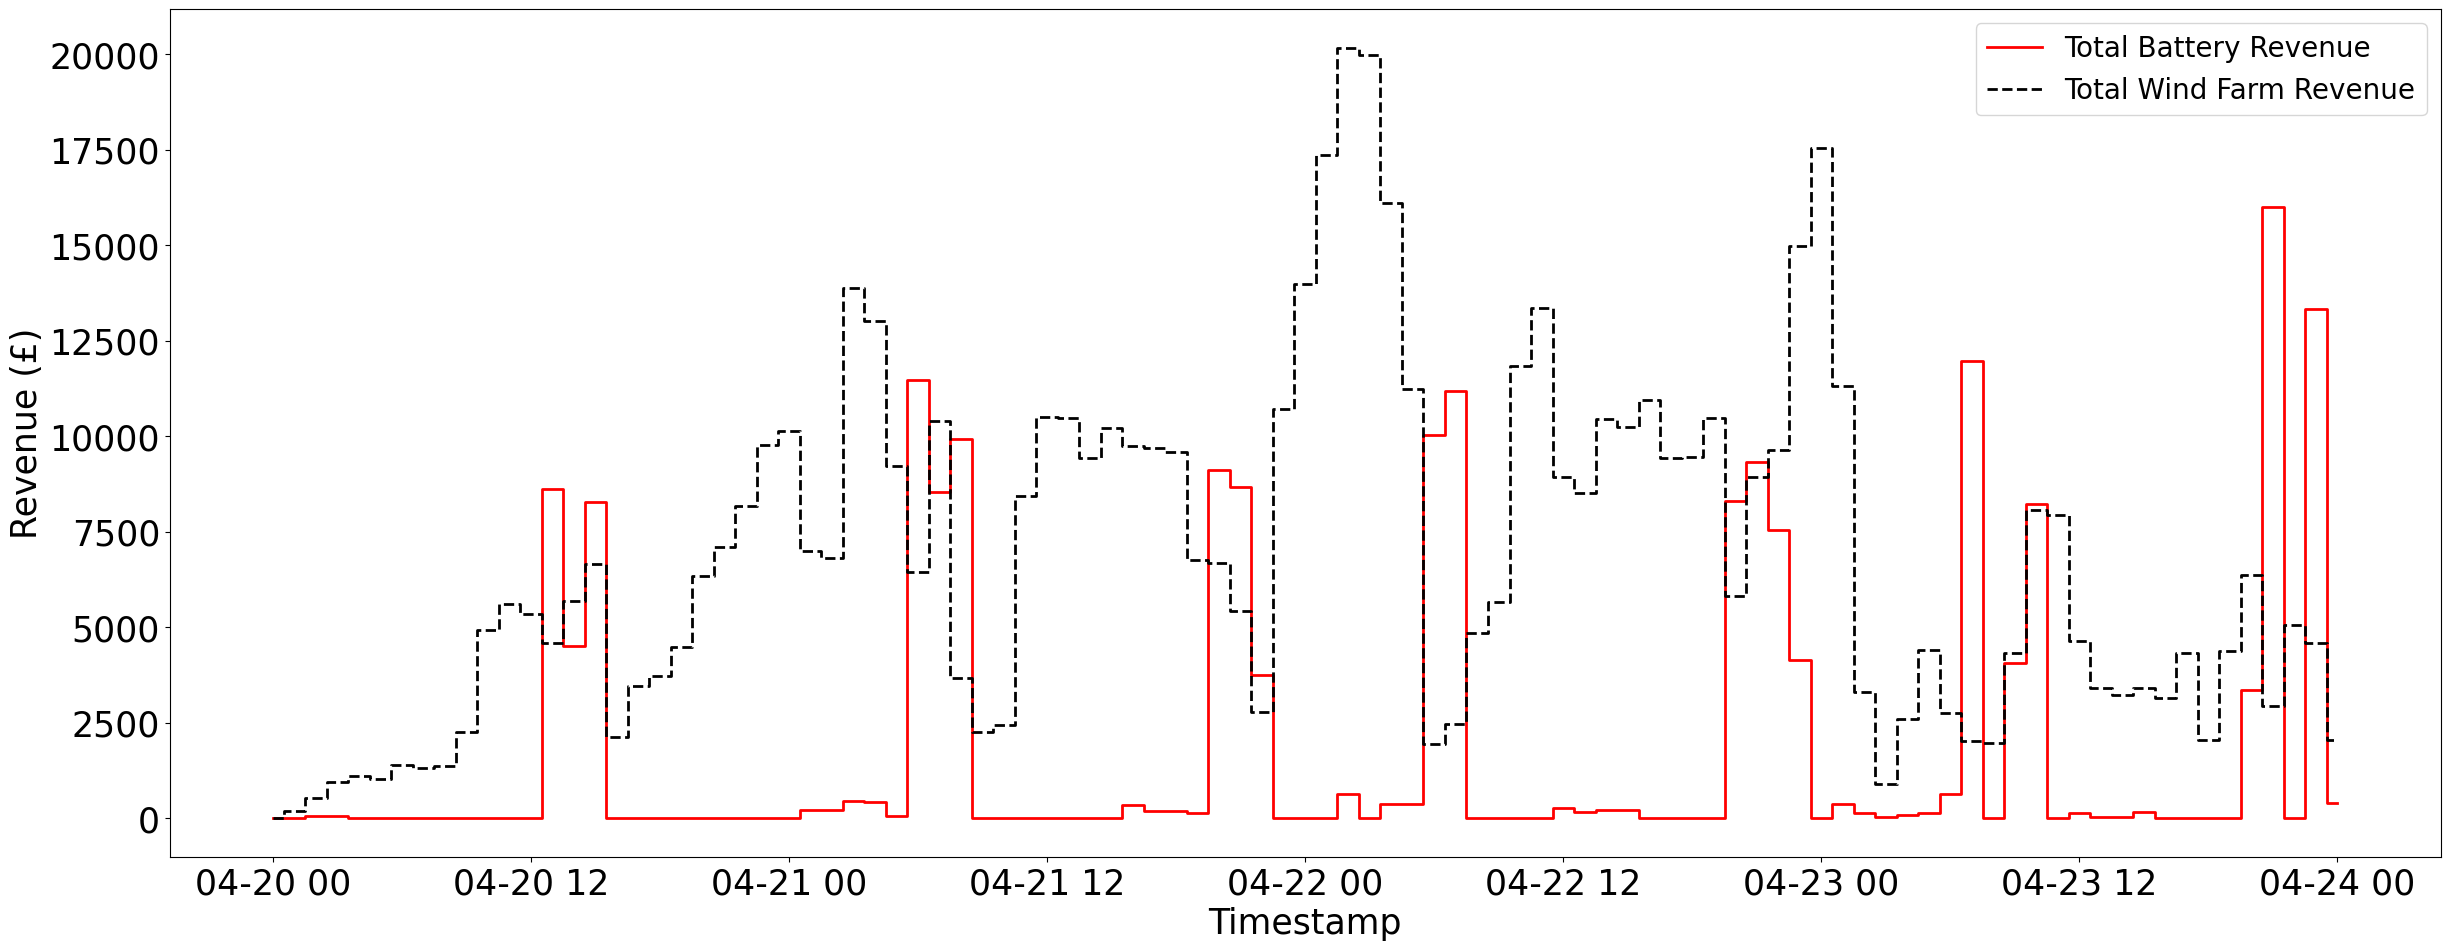

In [19]:
# Load the results data
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Optimization_Results_with_Revenue_2022_Two_Buses.xlsx'
data = pd.read_excel(file_path, parse_dates=['Timestamp'])

# Define the date range for plotting
start_date = '2022-04-20 00:00:00'
end_date = '2022-04-24 00:00:00'
mask = (data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)
filtered_data = data.loc[mask]

# Set font sizes
plt.rcParams.update({'font.size': 25})
label_fontsize = 25
legend_fontsize = 20
tick_fontsize = 25

# Plot the revenues
plt.figure(figsize=(25, 10))

plt.step(filtered_data['Timestamp'], filtered_data['Battery Revenue (£)'], where='mid', linestyle='-', linewidth=2, label='Total Battery Revenue', color='r')
plt.step(filtered_data['Timestamp'], filtered_data['CFD Revenue (£)'], where='mid', linestyle='--', linewidth=2, label='Total Wind Farm Revenue', color='k')

plt.xlabel('Timestamp', fontsize=label_fontsize)
plt.ylabel('Revenue (£)', fontsize=label_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.tight_layout()
plt.tight_layout(pad=1.0)

# Save the plot
output_image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Two Buses Result/Project_Revenue_Two_Buses.png'
plt.savefig(output_image_path, dpi=300, bbox_inches='tight', transparent=True)
print(f"Plot saved to {output_image_path}")

# Show the plot
plt.show()
